# Tutorial: KITTI Dataset

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-KITTI.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-KITTI.ipynb)       
**Author:** Kaikai Liu

## Install Pytorch

Pytorch is already installed in Colab. If you are installing the pytorch in your local machine, follow the tutorials here: from https://pytorch.org/get-started/locally/. You can check our pytorch installation tutorials for Mac/Windows/Linux/HPC here: https://deepdatamininglearning.readthedocs.io/

Click "Connect" to connect to a Colab VM instance. In Runtime->Change Runtime type to select CPU/TPU/GPU.

In [ ]:
!pip3 install torch torchvision

If the installed version of PyTorch is lower than required, uninstall it and reinstall again by running the following commands:

!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata

## Check PyTorch Environment

Pytorch is very similar to the `numpy` package. Let's start with importing PyTorch. The package is called `torch`, based on its original framework [Torch](http://torch.ch/). As a first step, we can check its version:

In [ ]:
!python -V

Python 3.12.11


In [ ]:
!nvidia-smi #check GPU

Tue Sep 16 23:28:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print("Using torch", torch.__version__)

Using torch 2.8.0+cu126


In [ ]:
x = torch.rand(5, 3)
print(x)

tensor([[0.6448, 0.0041, 0.6648],
        [0.7735, 0.5585, 0.0533],
        [0.9006, 0.0074, 0.5504],
        [0.7006, 0.9958, 0.7595],
        [0.9964, 0.1784, 0.3434]])


In [ ]:
import torchvision
print(torchvision.__version__)

0.23.0+cu126


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [ ]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  NVIDIA L4
Device properties: _CudaDeviceProperties(name='NVIDIA L4', major=8, minor=9, total_memory=22692MB, multi_processor_count=58, uuid=8c190c89-9d71-2ac3-c72d-deb8733cf349, pci_bus_id=0, pci_device_id=3, pci_domain_id=0, L2_cache_size=48MB)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.version.cuda

'12.6'

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
torch.backends.cudnn.version()

91002

In [ ]:
!echo $LD_LIBRARY_PATH

/usr/lib64-nvidia


As in every machine learning framework, PyTorch provides functions that are stochastic like generating random numbers. However, a very good practice is to setup your code to be reproducible with the exact same random numbers. This is why we set a seed below.

In [ ]:
torch.manual_seed(42) # Setting the seed

## Load Google Drive Folder for Colab

In Colab, add the following to load google drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
filename = os.path.join("/content/gdrive/My Drive/data", filename)

Check the following tutorial regarding the external data for Colab: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

## Download KITTI Dataset

In [ ]:
!pip install pykitti --quiet
!sudo apt-get install -y libgl1-mesa-glx > /dev/null

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
from urllib.request import urlretrieve
import zipfile
import glob

Download KITTI Dataset ~12 GB total.

In [ ]:
import os
from urllib.request import urlretrieve
import zipfile

os.makedirs("kitti_data", exist_ok=True)
os.chdir("kitti_data")

# KITTI object detection training set URLs
kitti_urls = {
    "images": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip",
    "labels": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip",
    "calib": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_calib.zip",
    "velodyne": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_velodyne.zip"
}

# Download and unzip each part
def download_and_unzip(name, url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        print(f"Downloading {name}...")
        urlretrieve(url, filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        print(f"Extracting {name}...")
        zip_ref.extractall()

for name, url in kitti_urls.items():
    download_and_unzip(name, url)

os.chdir("..")
print("✅ All KITTI data downloaded and extracted.")

Extracting images...
Extracting labels...
Extracting calib...
Extracting velodyne...
✅ All KITTI data downloaded and extracted.


In [ ]:
import os
import shutil
from zipfile import ZipFile
from IPython.display import FileLink

# Paths
full_base_dir = "kitti_data/training"
sample_base_dir = "kitti_sample_50"
sample_count = 50
zip_name = "kitti_sample_50.zip"

# Create new directory
if os.path.exists(sample_base_dir):
    shutil.rmtree(sample_base_dir)
os.makedirs(sample_base_dir)

# Subfolders to sample
subfolders = ['image_2', 'label_2', 'calib', 'velodyne']

for sub in subfolders:
    os.makedirs(os.path.join(sample_base_dir, sub), exist_ok=True)
    for i in range(sample_count):
        fname = f"{i:06d}.png" if sub == "image_2" else f"{i:06d}.txt" if sub == "label_2" or sub == "calib" else f"{i:06d}.bin"
        src = os.path.join(full_base_dir, sub, fname)
        dst = os.path.join(sample_base_dir, sub, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)

# Zip the folder
shutil.make_archive("kitti_sample_50", 'zip', sample_base_dir)

# Show download link
print("✅ Subset zip ready:")
display(FileLink(zip_name))

✅ Subset zip ready:


/content/kitti_sample_50.zip

## KITTI Dataset Code

1. Coordinate Systems in KITTI

    •	Image coordinates (2D):

    •	Origin: top-left corner
    •	(u, v) in pixels
    •	x \to right, y \to down

    •	Camera coordinates (3D, rectified):
    •	Origin: camera optical center
    •	X: right, Y: down, Z: forward
    •	Units: meters
    
    •	Velodyne LiDAR coordinates:
    •	Origin: LiDAR sensor
    •	X: forward, Y: left, Z: up
    •	Units: meters

⸻

2. KITTI Calibration Matrices

    •	Tr_velo_to_cam (3×4) → Velodyne → camera 0 extrinsic transform

    •	R0_rect (3×3) → rectification rotation (aligns cam0 to rectified frame)

    •	P{i} (3×4) → projection matrices for each camera (cam0–cam3)

In practice, we embed them into 4×4 homogeneous form:

Tr_velo_to_cam_4x4 = np.eye(4)
Tr_velo_to_cam_4x4[:3, :] = calib['Tr_velo_to_cam'].reshape(3, 4)

R0_rect_4x4 = np.eye(4)
R0_rect_4x4[:3, :3] = calib['R0_rect'].reshape(3, 3)



3. LiDAR → Image Projection

Homogeneous coordinates
	•	A 3D point (x, y, z) becomes:
X_{hom} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}

Transformation chain

$x_{img} \sim P_2 \cdot R_0^{rect} \cdot Tr_{velo \to cam} \cdot X_{velo}^{hom}$

Normalization

$u = \frac{u’}{w}, \quad v = \frac{v’}{w}$

where (u, v) are pixel coordinates.

⸻

4. Understanding Homogeneous Coordinates

	•	Add a 1 → enables rotation + translation as a single matrix multiply.

	•	Drop the 1 → to recover real-world 3D coordinates.

	•	Add back the 1 → before projection with P.

	•	Divide by w → de-homogenization to get pixels.

⸻

5. KITTI 3D Bounding Boxes

Each object label provides:

	•	dimensions = (h, w, l) in meters

	•	location = (x, y, z) in camera coords

	•	rotation_y yaw around Y-axis

Steps to compute corners

	1.	Define 8 corners in object coordinates:

\begin{aligned}
x_c &= [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2] \\
y_c &= [0, 0, 0, 0, -h, -h, -h, -h] \\
z_c &= [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
\end{aligned}

	2.	Apply rotation around Y:
$
R_y(\theta) =
\begin{bmatrix}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0 \\
-\sin\theta & 0 & \cos\theta
\end{bmatrix}$

	3.	Translate to object location (x, y, z).
	4.	Project corners with P_2 \cdot R_0^{rect}.
	5.	Normalize to pixels.

⸻

6. Drawing 3D Boxes in Image

	•	Connect projected corners as lines:

Bottom: [0–1, 1–2, 2–3, 3–0]

Top:    [4–5, 5–6, 6–7, 7–4]

Sides:  [0–4, 1–5, 2–6, 3–7]

	•	Use OpenCV cv2.line to draw.

In [ ]:
# Helper: Read calibration file
def read_calib_file(filepath):
    data = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if ':' not in line or line == '':
                continue  # Skip malformed lines
            key, value = line.split(':', 1)
            data[key] = np.array([float(x) for x in value.strip().split()])
    return data

# Helper: Read label file
def read_label_file(filepath):
    labels = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            obj = {
                'type': parts[0],
                'truncated': float(parts[1]),
                'occluded': int(parts[2]),
                'alpha': float(parts[3]),
                'bbox': np.array([float(x) for x in parts[4:8]]), # 2D bbox
                'dimensions': np.array([float(x) for x in parts[8:11]]), # h, w, l
                'location': np.array([float(x) for x in parts[11:14]]), # x, y, z
                'rotation_y': float(parts[14])
            }
            labels.append(obj)
    return labels

# Helper: Read Velodyne Lidar file
def read_velodyne_bin(filepath):
    return np.fromfile(filepath, dtype=np.float32).reshape(-1, 4)

# Project Lidar to Image
def project_lidar_to_img(pc_lidar, P2, R0_rect, Tr_velo_to_cam, img_shape):
    # Step 1: Homogeneous coords (N, 4)
    pc_velo_hom = np.hstack((pc_lidar[:, :3], np.ones((pc_lidar.shape[0], 1))))  # (N, 4)

    # Step 2: Lidar -> Camera coords
    pc_cam = (R0_rect @ Tr_velo_to_cam @ pc_velo_hom.T).T  # (N, 4)

    # Step 3: Only keep 3D points (drop homogeneous 4th coord)
    pc_cam_xyz = pc_cam[:, :3]

    # Step 4: Project to image
    pc_cam_xyz_hom = np.hstack((pc_cam_xyz, np.ones((pc_cam_xyz.shape[0], 1))))  # (N, 4)
    pts_2d = (P2 @ pc_cam_xyz_hom.T).T  # (N, 3)

    # Normalize
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]

    # Filter valid points inside image and in front of camera
    x_img = pts_2d[:, 0]
    y_img = pts_2d[:, 1]
    z = pc_cam[:, 2]

    valid = (x_img >= 0) & (x_img < img_shape[1]) & \
            (y_img >= 0) & (y_img < img_shape[0]) & \
            (z > 0)

    return x_img[valid].astype(int), y_img[valid].astype(int), z[valid]

# Draw 2D bounding boxes
def draw_2d_boxes(img, labels):
    for obj in labels:
        x1, y1, x2, y2 = obj['bbox']
        color = (0, 255, 0)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        cv2.putText(img, obj['type'], (int(x1), int(y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

def draw_3d_boxes(img, labels, P2, R0_rect, Tr_velo_to_cam):
    def compute_box_3d(obj):
        h, w, l = obj['dimensions']
        x, y, z = obj['location']
        ry = obj['rotation_y']

        # 3D bounding box corners in object coordinate system
        x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
        y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
        z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
        corners_3d = np.array([x_corners, y_corners, z_corners])  # (3,8)

        # Rotation around Y-axis
        R = rotation_matrix(ry)
        corners_3d = R @ corners_3d
        corners_3d += np.array([[x], [y], [z]])

        return corners_3d  # (3,8)

    def project_to_image(corners_3d):
        # Convert to homogeneous coordinates
        num_points = corners_3d.shape[1]
        corners_3d_hom = np.vstack((corners_3d, np.ones((1, num_points))))  # (4,8)

        # Project: velo → camera rect → image
        #pts_2d = P2 @ R0_rect @ Tr_velo_to_cam @ corners_3d_hom  # (3,8)
        pts_2d = P2 @ R0_rect @ corners_3d_hom
        pts_2d[:2] /= pts_2d[2] + 1e-6  # avoid divide by zero

        return pts_2d[:2].T.astype(np.int32)  # (8,2)

    def draw_box(img, corners_img):
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # bottom
            [4, 5], [5, 6], [6, 7], [7, 4],  # top
            [0, 4], [1, 5], [2, 6], [3, 7]   # vertical
        ]
        for i, j in lines:
            pt1, pt2 = corners_img[i], corners_img[j]
            if np.all(pt1 >= 0) and np.all(pt2 >= 0):  # sanity check
                cv2.line(img, tuple(pt1), tuple(pt2), color=(255, 0, 0), thickness=2)
        return img

    img_out = img.copy()

    for obj in labels:
        if obj['type'].lower() == 'dontcare':
            continue
        corners_3d = compute_box_3d(obj)
        corners_img = project_to_image(corners_3d)
        img_out = draw_box(img_out, corners_img)

    return img_out

def draw_box_lines(img, pts):
    # 12 lines of a 3D box
    lines = [
        [0,1], [1,2], [2,3], [3,0],  # lower rectangle
        [4,5], [5,6], [6,7], [7,4],  # upper rectangle
        [0,4], [1,5], [2,6], [3,7],  # vertical lines
    ]
    for i, j in lines:
        if np.any(pts[i] < 0) or np.any(pts[j] < 0):
            continue
        cv2.line(img, tuple(pts[i]), tuple(pts[j]), color=(255, 0, 0), thickness=2)
    return img

def rotation_matrix(ry):
    R = np.array([
        [ np.cos(ry), 0, np.sin(ry)],
        [0, 1, 0],
        [-np.sin(ry), 0, np.cos(ry)]
    ])
    return R


In [ ]:
def draw_lidar_on_image(img, x_img, y_img, z_depth, max_depth=70):
    """
    Overlay Lidar points on image, colored by depth using colormap.
    """
    img_out = img.copy()

    # Normalize depth to [0, 255]
    depth_normalized = np.clip(z_depth / max_depth, 0, 1)
    depth_colormap = (255 * depth_normalized).astype(np.uint8)

    # Apply OpenCV colormap (JET = blue → green → red → yellow)
    colors = cv2.applyColorMap(depth_colormap, cv2.COLORMAP_JET)  # shape (N, 3)

    # Draw each point
    for x, y, color in zip(x_img, y_img, colors):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            #cv2.circle(img_out, (x, y), radius=1, color=tuple(int(c) for c in color), thickness=-1)
            cv2.circle(img_out, (x, y), radius=1, color=tuple(color.flatten().tolist()), thickness=-1)

    return img_out

## Read and Visualize KITTI Data

In [ ]:
base_dir='./kitti_data/training'

In [ ]:
idx = "000000"
image = cv2.imread(f"{base_dir}/image_2/{idx}.png")
labels = read_label_file(f"{base_dir}/label_2/{idx}.txt")
calib = read_calib_file(f"{base_dir}/calib/{idx}.txt")
lidar = read_velodyne_bin(f"{base_dir}/velodyne/{idx}.bin")

In [ ]:
for obj in labels:
    print(f"{obj['type']}: loc={obj['location']}, dim={obj['dimensions']}, ry={obj['rotation_y']}")

Car: loc=[-15.71   2.16  38.26], dim=[1.49 1.76 4.01], ry=1.57
Car: loc=[-15.89   2.23  51.17], dim=[1.38 1.8  3.41], ry=1.58
DontCare: loc=[-1000. -1000. -1000.], dim=[-1. -1. -1.], ry=-10.0
DontCare: loc=[-1000. -1000. -1000.], dim=[-1. -1. -1.], ry=-10.0
DontCare: loc=[-1000. -1000. -1000.], dim=[-1. -1. -1.], ry=-10.0
DontCare: loc=[-1000. -1000. -1000.], dim=[-1. -1. -1.], ry=-10.0
DontCare: loc=[-1000. -1000. -1000.], dim=[-1. -1. -1.], ry=-10.0


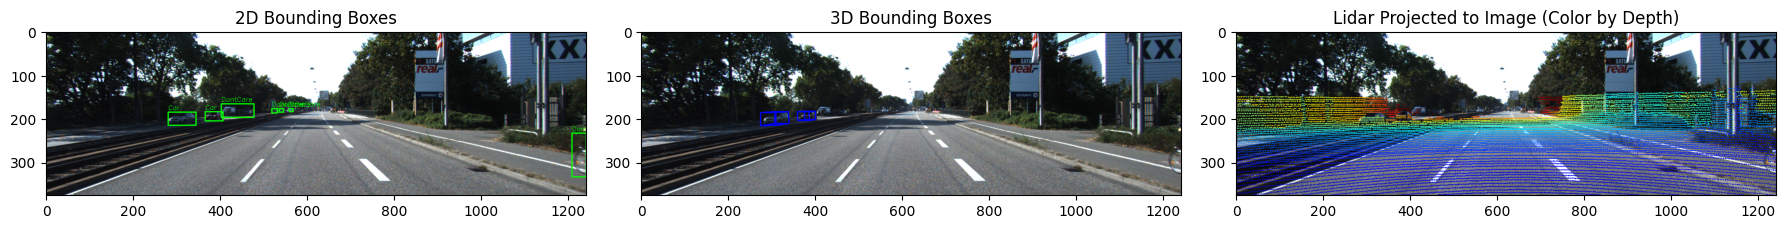

In [ ]:
# --- Parse Calibration Matrices ---
P2 = calib['P2'].astype(np.float32).reshape(3, 4)

R0_rect = np.eye(4, dtype=np.float32)
R0_rect[:3, :3] = calib['R0_rect'].astype(np.float32).reshape(3, 3) #(3,3)=>(4,4)

Tr_velo_to_cam = np.eye(4, dtype=np.float32)
Tr_velo_to_cam[:3, :] = calib['Tr_velo_to_cam'].astype(np.float32).reshape(3, 4) #(3,4)=>(4,4)

# --- Visualize Boxes ---
img_copy = image.copy()
img_2d = draw_2d_boxes(img_copy.copy(), labels)
img_3d = draw_3d_boxes(img_copy.copy(), labels, P2, R0_rect, Tr_velo_to_cam)

# --- Project Lidar ---
x_img, y_img, z = project_lidar_to_img(lidar, P2, R0_rect, Tr_velo_to_cam, image.shape)

# --- Draw Lidar Points Colored by Depth ---
img_lidar = draw_lidar_on_image(image, x_img, y_img, z, max_depth=70)

# --- Show Results ---
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB))
plt.title("2D Bounding Boxes")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB))
plt.title("3D Bounding Boxes")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB))
plt.title("Lidar Projected to Image (Color by Depth)")

plt.tight_layout()
plt.show()

📷 Frame 000000


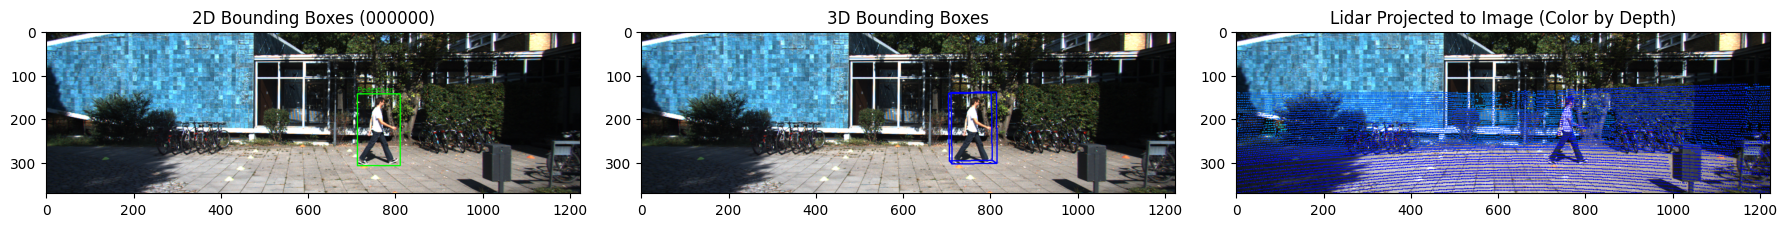

📷 Frame 000001


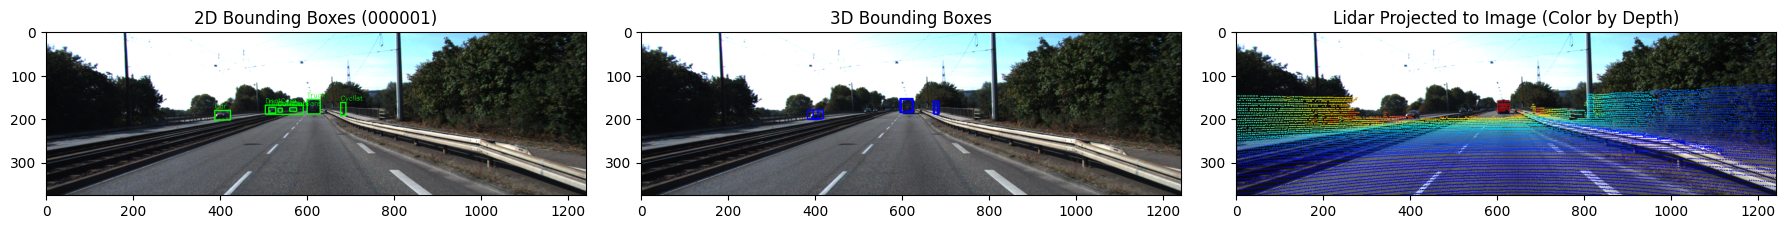

📷 Frame 000002


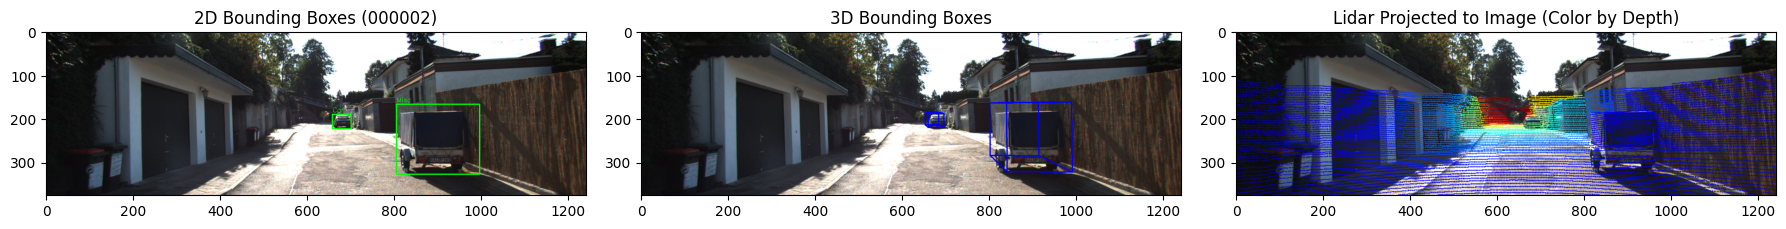

📷 Frame 000003


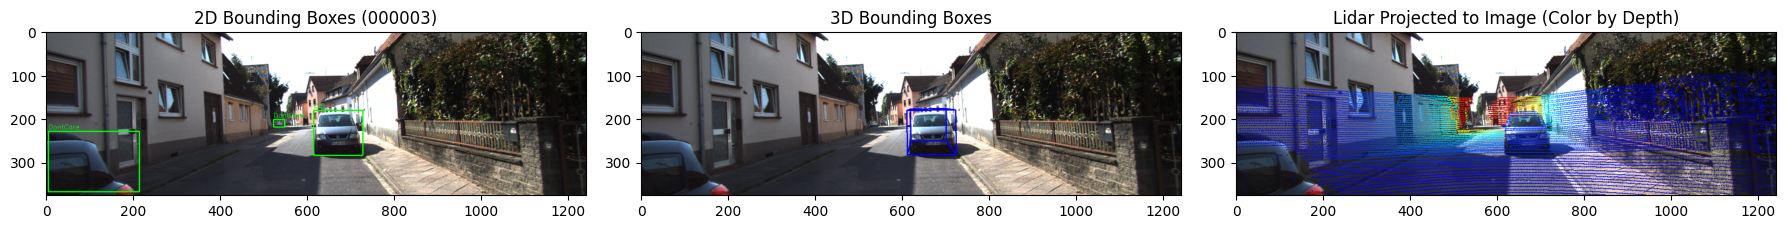

📷 Frame 000004


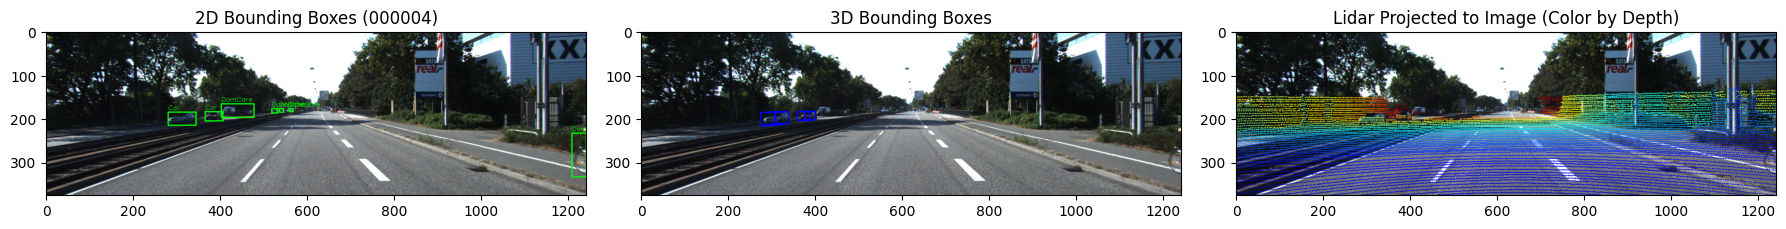

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import os

base_dir = "kitti_data/training"
sample_ids = sorted([f.split('.')[0] for f in os.listdir(f"{base_dir}/image_2")])[:5]  # First 5 frames

for idx in sample_ids:
    print(f"📷 Frame {idx}")

    # --- Load Data ---
    image = cv2.imread(f"{base_dir}/image_2/{idx}.png")
    labels = read_label_file(f"{base_dir}/label_2/{idx}.txt")
    calib = read_calib_file(f"{base_dir}/calib/{idx}.txt")
    lidar = read_velodyne_bin(f"{base_dir}/velodyne/{idx}.bin")

    # --- Parse Calibration ---
    P2 = calib['P2'].astype(np.float32).reshape(3, 4)
    R0_rect = np.eye(4, dtype=np.float32)
    R0_rect[:3, :3] = calib['R0_rect'].astype(np.float32).reshape(3, 3)
    Tr_velo_to_cam = np.eye(4, dtype=np.float32)
    Tr_velo_to_cam[:3, :] = calib['Tr_velo_to_cam'].astype(np.float32).reshape(3, 4)

    # --- Visualize ---
    img_2d = draw_2d_boxes(image.copy(), labels)
    img_3d = draw_3d_boxes(image.copy(), labels, P2, R0_rect, Tr_velo_to_cam)

    # --- Project Lidar to Image ---
    x_img, y_img, z = project_lidar_to_img(lidar, P2, R0_rect, Tr_velo_to_cam, image.shape)
    img_lidar = draw_lidar_on_image(image.copy(), x_img, y_img, z, max_depth=70)

    # --- Plot Results ---
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB))
    plt.title(f"2D Bounding Boxes ({idx})")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB))
    plt.title("3D Bounding Boxes")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB))
    plt.title("Lidar Projected to Image (Color by Depth)")

    plt.tight_layout()
    plt.show()

📷 Frame 000000


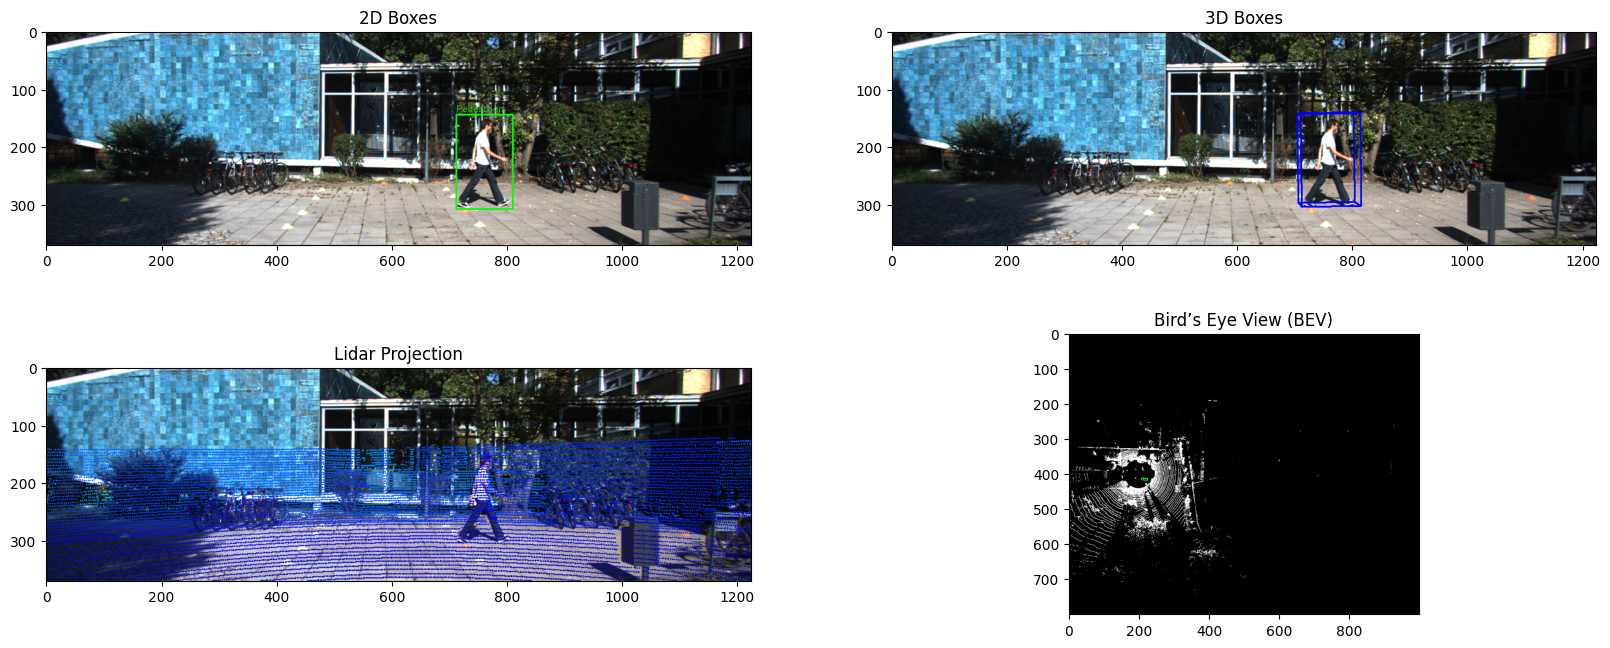

📷 Frame 000001


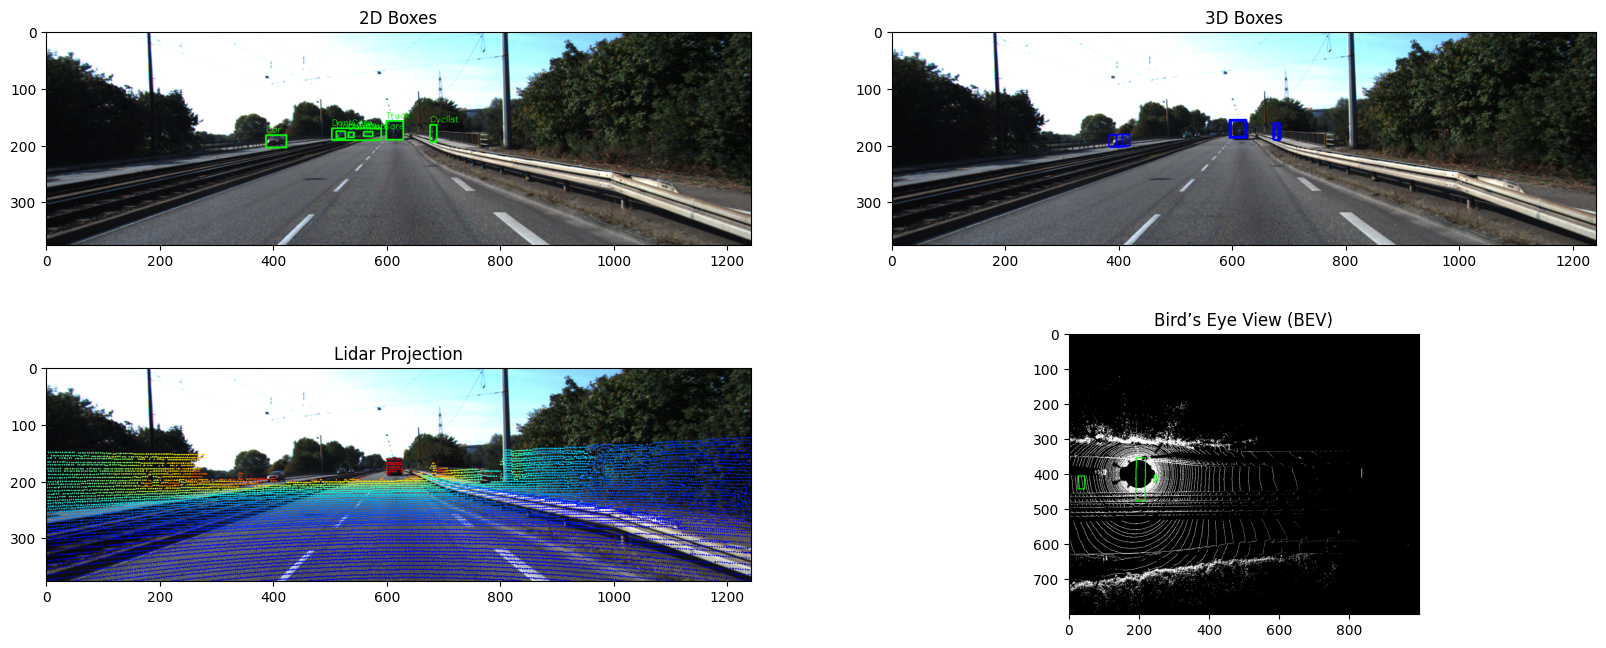

📷 Frame 000002


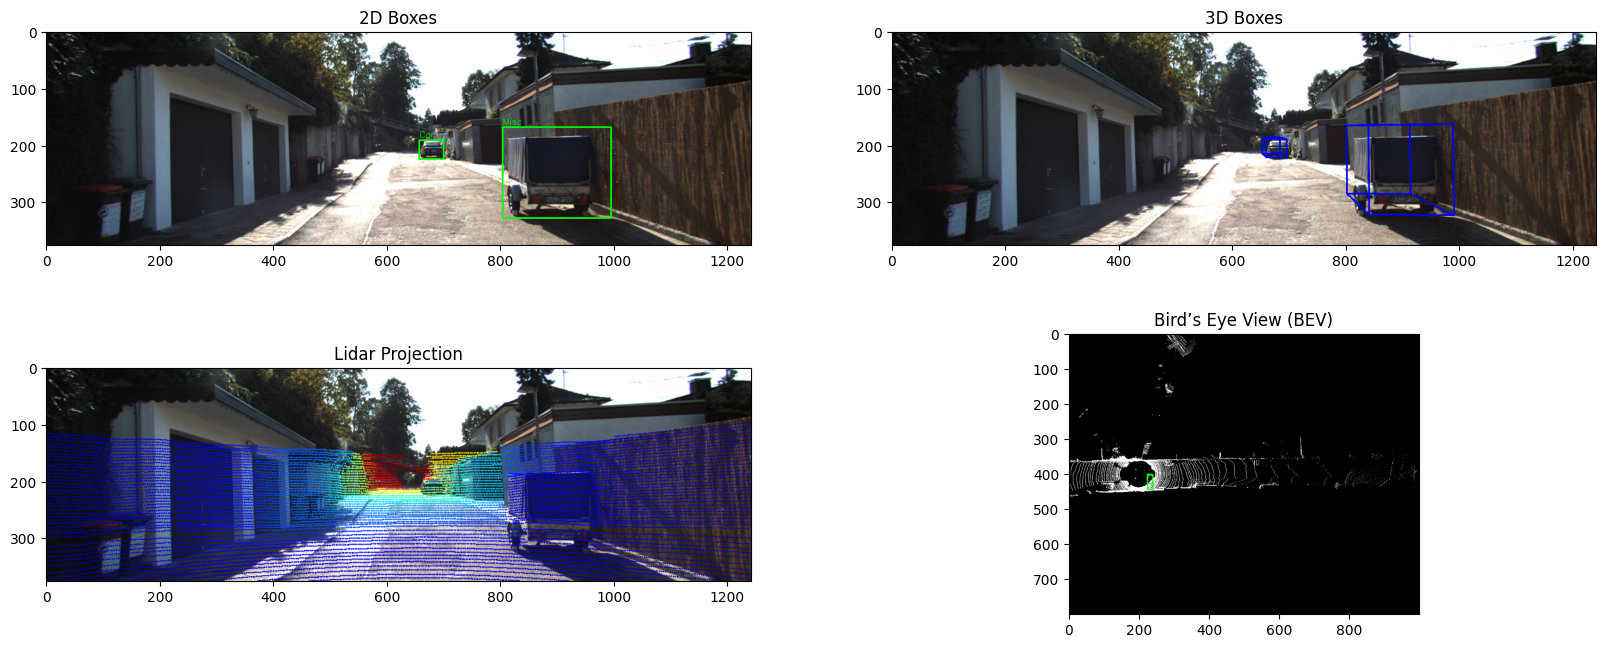

📷 Frame 000003


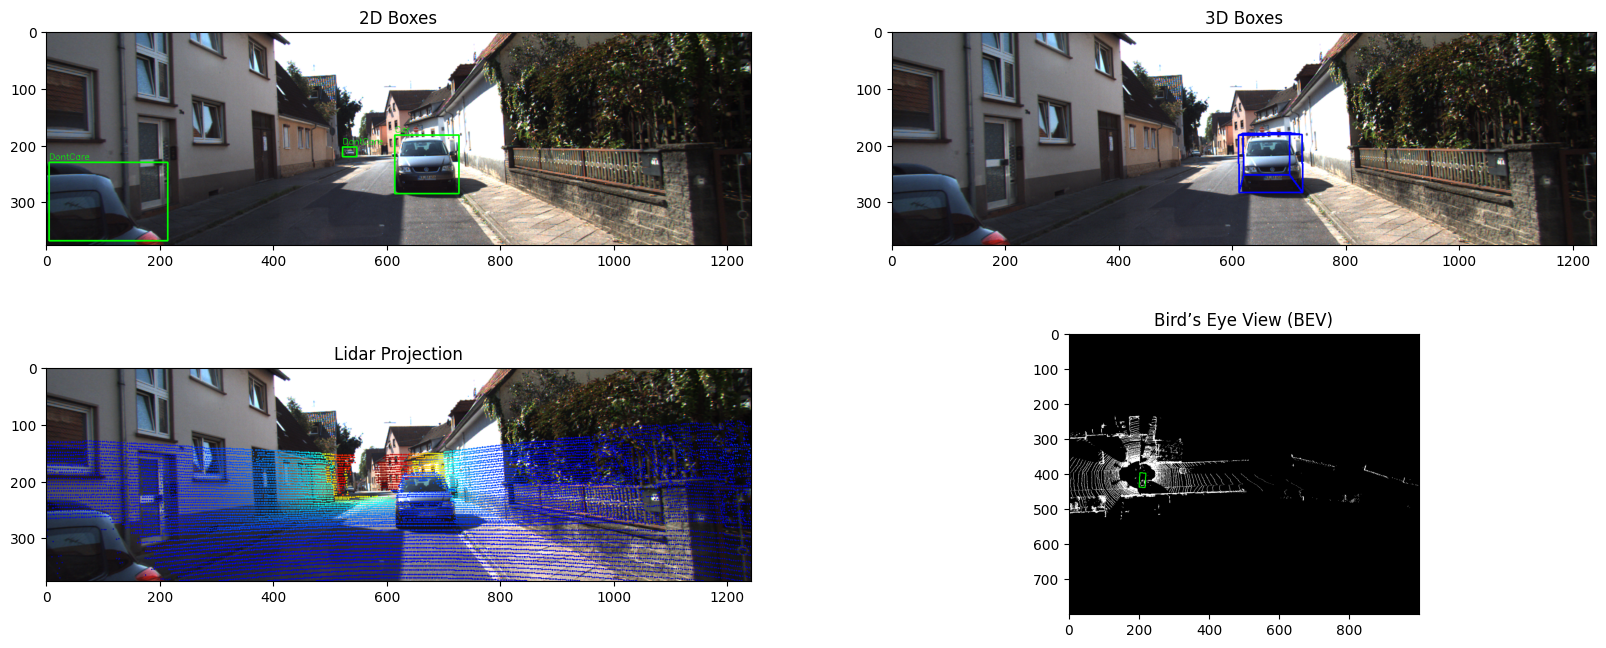

📷 Frame 000004


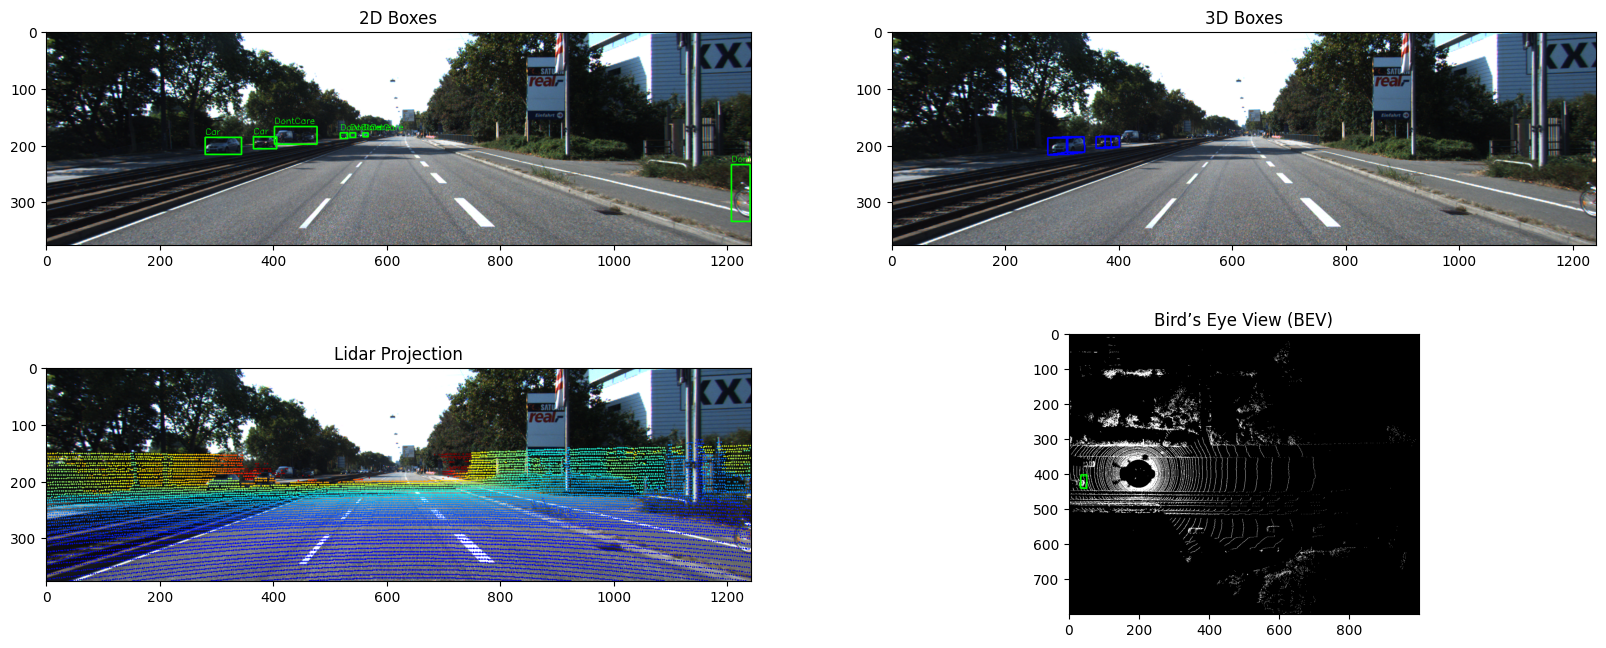

🎥 Saved `kitti_output.mp4` and individual frames in `output_kitti_frames/`.


In [ ]:
import os
from matplotlib.patches import Rectangle
import imageio

def resize_and_annotate(img, label, size=(1242, 375), color=(255, 255, 255)):
    img = cv2.resize(img, size)
    cv2.putText(img, label, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return img

os.makedirs("output_kitti_frames", exist_ok=True)

def draw_bev(lidar, labels=None, x_range=(-20, 80), y_range=(-40, 40), resolution=0.1):
    bev_map = np.zeros((int((y_range[1] - y_range[0]) / resolution),
                        int((x_range[1] - x_range[0]) / resolution), 3), dtype=np.uint8)
    for point in lidar:
        x, y, z, r = point
        if x_range[0] <= x <= x_range[1] and y_range[0] <= y <= y_range[1]:
            px = int((x - x_range[0]) / resolution)
            py = int((y - y_range[0]) / resolution)
            bev_map[py, px] = [255, 255, 255]

    if labels:
        for obj in labels:
            if obj['type'] == 'DontCare':
                continue
            h, w, l = obj['dimensions']
            x, y, z = obj['location']
            ry = obj['rotation_y']
            corners = np.array([
                [l/2, w/2], [l/2, -w/2],
                [-l/2, -w/2], [-l/2, w/2]
            ])
            rot = np.array([[np.cos(ry), -np.sin(ry)],
                            [np.sin(ry),  np.cos(ry)]])
            corners = corners @ rot.T
            corners += [x, y]

            px = ((corners[:,0] - x_range[0]) / resolution).astype(int)
            py = ((corners[:,1] - y_range[0]) / resolution).astype(int)
            for i in range(4):
                cv2.line(bev_map, (px[i], py[i]), (px[(i+1)%4], py[(i+1)%4]), (0,255,0), 2)
    return bev_map

# Optional video writer
#video_writer = cv2.VideoWriter('kitti_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (1242, 375))
frame_width = 1242 * 2  # 2 images side-by-side
frame_height = 375 * 2  # 2 rows
video_writer = cv2.VideoWriter(
    'kitti_output.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    2,  # fps
    (frame_width, frame_height)
)

frame_idx = 0
for idx in sample_ids:
    print(f"📷 Frame {idx}")
    image = cv2.imread(f"{base_dir}/image_2/{idx}.png")
    labels = read_label_file(f"{base_dir}/label_2/{idx}.txt")
    calib = read_calib_file(f"{base_dir}/calib/{idx}.txt")
    lidar = read_velodyne_bin(f"{base_dir}/velodyne/{idx}.bin")

    P2 = calib['P2'].reshape(3, 4)
    R0_rect = np.eye(4)
    R0_rect[:3, :3] = calib['R0_rect'].reshape(3, 3)
    Tr_velo_to_cam = np.eye(4)
    Tr_velo_to_cam[:3, :] = calib['Tr_velo_to_cam'].reshape(3, 4)

    img_2d = draw_2d_boxes(image.copy(), labels)
    img_3d = draw_3d_boxes(image.copy(), labels, P2, R0_rect, Tr_velo_to_cam)

    # Project lidar to image
    x_img, y_img, z = project_lidar_to_img(lidar, P2, R0_rect, Tr_velo_to_cam, image.shape)
    img_lidar = draw_lidar_on_image(image, x_img, y_img, z, max_depth=70)

    bev = draw_bev(lidar, labels)

    # Save images
    cv2.imwrite(f"output_kitti_frames/{frame_idx:03d}_2d.png", img_2d)
    cv2.imwrite(f"output_kitti_frames/{frame_idx:03d}_3d.png", img_3d)
    cv2.imwrite(f"output_kitti_frames/{frame_idx:03d}_lidar.png", img_lidar)
    cv2.imwrite(f"output_kitti_frames/{frame_idx:03d}_bev.png", bev)

    # Show preview
    plt.figure(figsize=(20, 8))
    plt.subplot(2,2,1)
    plt.imshow(cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB))
    plt.title("2D Boxes")

    plt.subplot(2,2,2)
    plt.imshow(cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB))
    plt.title("3D Boxes")

    plt.subplot(2,2,3)
    plt.imshow(cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB))
    plt.title("Lidar Projection")

    plt.subplot(2,2,4)
    plt.imshow(cv2.cvtColor(bev, cv2.COLOR_BGR2RGB))
    plt.title("Bird’s Eye View (BEV)")

    plt.show()

    # Add to video
    img_2d     = resize_and_annotate(img_2d, "2D Boxes", color=(0,255,0))
    img_3d     = resize_and_annotate(img_3d, "3D Boxes", color=(255,0,0))
    img_lidar  = resize_and_annotate(img_lidar, "Lidar Projection", color=(0,0,255))
    bev_color  = cv2.cvtColor(bev, cv2.COLOR_RGB2BGR) if bev.shape[2] == 3 else cv2.cvtColor(cv2.merge([bev]*3), cv2.COLOR_RGB2BGR)
    bev_resized = resize_and_annotate(bev_color, "Bird's Eye View", color=(0,255,255))

    top_row = np.hstack((img_2d, img_3d))
    bottom_row = np.hstack((img_lidar, bev_resized))
    combined = np.vstack((top_row, bottom_row))

    # Ensure correct size and type for video writer
    if frame_idx == 0:
        h, w = combined.shape[:2]
        video_writer = cv2.VideoWriter('kitti_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (w, h))

    video_writer.write(combined)

    frame_idx += 1

video_writer.release()
print("🎥 Saved `kitti_output.mp4` and individual frames in `output_kitti_frames/`.")

## Object Detection via Torchvision and YOLO

In [ ]:
!pip install -q torchvision ultralytics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from ultralytics import YOLO
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

# Define KITTI -> COCO categories
kitti_to_coco_map = {
    'Car': 'car',
    'Van': 'car',
    'Truck': 'truck',
    'Pedestrian': 'person',
    'Person_sitting': 'person',
    'Cyclist': 'bicycle',
    'Tram': 'train',
    'Misc': 'other'
}

coco_categories = [
    {'id': 1, 'name': 'person'},
    {'id': 2, 'name': 'car'},
    {'id': 3, 'name': 'truck'},
    {'id': 4, 'name': 'bicycle'},
    {'id': 5, 'name': 'train'},
    {'id': 6, 'name': 'other'},
]

cat_name_to_id = {cat['name']: cat['id'] for cat in coco_categories}

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

fasterrcnn = fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn = fasterrcnn.eval().to(device)

yolo = YOLO('yolov8n.pt')  # Use small model for speed

# Input setup
image_dir = "kitti_data/training/image_2"
label_dir = "kitti_data/training/label_2"
image_ids = sorted(os.listdir(image_dir))[:20]  # use 20 frames for demo

transform = T.Compose([
    T.ToTensor()
])

gt_annotations = []
pred_annotations = []
pred_frcnn = []
pred_yolo = []
images = []
ann_id = 1
img_id = 1

for fname in tqdm(image_ids):
    image_path = os.path.join(image_dir, fname)
    label_path = os.path.join(label_dir, fname.replace(".png", ".txt"))

    # Load image
    image = Image.open(image_path).convert("RGB")
    img_w, img_h = image.size
    images.append({"id": img_id, "file_name": fname, "width": img_w, "height": img_h})

    # Load GT boxes
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            obj_type = parts[0]
            if obj_type == 'DontCare' or obj_type not in kitti_to_coco_map:
                continue
            coco_name = kitti_to_coco_map[obj_type]
            coco_id = cat_name_to_id[coco_name]
            bbox = list(map(float, parts[4:8]))  # x1, y1, x2, y2
            x1, y1, x2, y2 = bbox
            w, h = x2 - x1, y2 - y1
            gt_annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": coco_id,
                "bbox": [x1, y1, w, h],
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    # Predict (FasterRCNN)
    with torch.no_grad():
        input_tensor = transform(image).unsqueeze(0).to(device)
        outputs = fasterrcnn(input_tensor)[0]

    for box, score, label in zip(outputs['boxes'], outputs['scores'], outputs['labels']):
        if score < 0.3:
            continue
        coco_label = label.item()
        if coco_label not in cat_name_to_id.values():
            continue
        x1, y1, x2, y2 = box.tolist()
        w, h = x2 - x1, y2 - y1
        pred_frcnn.append({
            "image_id": img_id,
            "category_id": coco_label,
            "bbox": [x1, y1, w, h],
            "score": float(score)
        })

    # Predict (YOLOv8)
    results = yolo(image_path, verbose=False)[0]
    for box, cls, conf in zip(results.boxes.xyxy.cpu().numpy(),
                              results.boxes.cls.cpu().numpy(),
                              results.boxes.conf.cpu().numpy()):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        coco_name = yolo.names[int(cls)]
        if coco_name not in cat_name_to_id:
            continue
        coco_id = cat_name_to_id[coco_name]
        pred_yolo.append({
            "image_id": img_id,
            "category_id": coco_id,
            "bbox": [x1, y1, w, h],
            "score": float(conf)
        })

    img_id += 1

# --- Save annotations to file
gt_coco = {
    "info": {"description": "KITTI detection GT in COCO format"},
    "licenses": [],
    "images": images,
    "annotations": gt_annotations,
    "categories": coco_categories
}

with open("gt.json", "w") as f:
    json.dump(gt_coco, f)

# Convert to native Python types
# for ann in pred_annotations:
#     ann["bbox"] = [float(v) for v in ann["bbox"]]
#     ann["score"] = float(ann["score"])
#     ann["category_id"] = int(ann["category_id"])

# Ensure all values are native Python types
for ann in pred_yolo:
    ann["bbox"] = [float(v) for v in ann["bbox"]]
    ann["score"] = float(ann["score"])
    ann["category_id"] = int(ann["category_id"])
    ann["image_id"] = int(ann["image_id"])

# Ensure all values are native Python types
for ann in pred_frcnn:
    ann["bbox"] = [float(v) for v in ann["bbox"]]
    ann["score"] = float(ann["score"])
    ann["category_id"] = int(ann["category_id"])
    ann["image_id"] = int(ann["image_id"])

# with open("pred.json", "w") as f:
#     json.dump(pred_annotations, f)
with open("pred_frcnn.json", "w") as f:
    json.dump(pred_frcnn, f)

with open("pred_yolo.json", "w") as f:
    json.dump(pred_yolo, f)

# --- COCO Evaluation ---
coco_gt = COCO("gt.json")

# FasterRCNN
print("\n🔵 Evaluating Faster R-CNN:")
coco_dt_frcnn = coco_gt.loadRes("pred_frcnn.json")
eval_frcnn = COCOeval(coco_gt, coco_dt_frcnn, "bbox")
eval_frcnn.evaluate()
eval_frcnn.accumulate()
eval_frcnn.summarize()

# YOLOv8
print("\n🔴 Evaluating YOLOv8:")
coco_dt_yolo = coco_gt.loadRes("pred_yolo.json")
eval_yolo = COCOeval(coco_gt, coco_dt_yolo, "bbox")
eval_yolo.evaluate()
eval_yolo.accumulate()
eval_yolo.summarize()

100%|██████████| 20/20 [00:01<00:00, 14.20it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

🔵 Evaluating Faster R-CNN:
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:

## KITTI to COCO and YOLO format

In [ ]:
import os
import json
import shutil
from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import torch
from ultralytics import YOLO

# Paths
base_dir = "kitti_data/training"
image_dir = os.path.join(base_dir, "image_2")
label_dir = os.path.join(base_dir, "label_2")

# Output paths
os.makedirs("kitti_coco/images", exist_ok=True)
os.makedirs("kitti_coco/annotations", exist_ok=True)
os.makedirs("kitti_yolo/images/train", exist_ok=True)
os.makedirs("kitti_yolo/labels/train", exist_ok=True)

# Category mapping (simplified COCO)
kitti_to_coco = {
    'Car': 0,
    'Pedestrian': 1,
    'Cyclist': 2
}

coco_categories = [
    {"id": 1, "name": "car"},
    {"id": 2, "name": "person"},
    {"id": 3, "name": "bicycle"}
]

images = []
annotations = []
img_id = 1
ann_id = 1

image_list = sorted(os.listdir(image_dir))[:200]  # Use 200 samples for demo

for fname in tqdm(image_list):
    img_path = os.path.join(image_dir, fname)
    lbl_path = os.path.join(label_dir, fname.replace(".png", ".txt"))

    im = Image.open(img_path)
    w, h = im.size
    shutil.copy(img_path, f"kitti_coco/images/{fname}")
    shutil.copy(img_path, f"kitti_yolo/images/train/{fname}")
    images.append({"file_name": fname, "height": h, "width": w, "id": img_id})

    with open(lbl_path, 'r') as f:
        yolo_lines = []
        for line in f:
            parts = line.strip().split()
            cls = parts[0]
            if cls not in kitti_to_coco:
                continue
            cat_id = kitti_to_coco[cls]
            x1, y1, x2, y2 = map(float, parts[4:8])
            width, height = x2 - x1, y2 - y1
            x_center = (x1 + x2) / 2 / w
            y_center = (y1 + y2) / 2 / h
            norm_w = width / w
            norm_h = height / h

            # YOLO format
            yolo_lines.append(f"{cat_id} {x_center} {y_center} {norm_w} {norm_h}")

            # COCO format
            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cat_id + 1,
                "bbox": [x1, y1, width, height],
                "area": width * height,
                "iscrowd": 0
            })
            ann_id += 1

    # Save YOLO label file
    yolo_label_path = f"kitti_yolo/labels/train/{fname.replace('.png', '.txt')}"
    with open(yolo_label_path, "w") as f:
        f.write("\n".join(yolo_lines))
    img_id += 1

# Write COCO annotation file
coco_anno = {
    "info": {"description": "KITTI COCO-format"},
    "licenses": [],
    "images": images,
    "annotations": annotations,
    "categories": coco_categories
}
with open("kitti_coco/annotations/instances_train.json", "w") as f:
    json.dump(coco_anno, f)

# Write YOLO data.yaml
with open("kitti_yolo/data.yaml", "w") as f:
    f.write("""\
path: ../kitti_yolo
train: images/train
val: images/train
names:
  0: car
  1: person
  2: bicycle
""")

100%|██████████| 200/200 [00:01<00:00, 136.11it/s]


## FasterRCNN Training

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load dataset
transform = lambda img, target: (F.to_tensor(img), target)
dataset = CocoDetection(
    root="kitti_coco/images",
    annFile="kitti_coco/annotations/instances_train.json",
    transforms=transform
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Model setup
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    print(f"\n🌀 Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0.0

    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]

        # Convert COCO annotations to FasterRCNN format
        converted_targets = []
        for ann_list in targets:
            boxes = []
            labels = []
            for ann in ann_list:
                boxes.append(torch.tensor(ann["bbox"]))
                labels.append(torch.tensor(ann["category_id"]))
            if boxes:
                boxes = torch.stack(boxes)
                boxes[:, 2:] += boxes[:, :2]  # [x, y, w, h] → [x1, y1, x2, y2]
            else:
                boxes = torch.zeros((0, 4))
                labels = torch.zeros((0,), dtype=torch.int64)
            converted_targets.append({
                "boxes": boxes.to(device).float(),
                "labels": torch.tensor(labels).to(device).long()
            })

        # Forward + Backward + Optimize
        loss_dict = model(images, converted_targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        print(f"Batch Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"✅ Epoch {epoch + 1} finished. Average Loss: {avg_loss:.4f}")

    # ✅ Save model after each epoch
    checkpoint_path = f"model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"💾 Saved model checkpoint to {checkpoint_path}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

🌀 Epoch 1/10


  1%|          | 1/100 [00:00<00:18,  5.24it/s]

Batch Loss: 1.4945


  2%|▏         | 2/100 [00:00<00:18,  5.40it/s]

Batch Loss: 1.5591


  3%|▎         | 3/100 [00:00<00:17,  5.43it/s]

Batch Loss: 0.6700


  4%|▍         | 4/100 [00:00<00:17,  5.44it/s]

Batch Loss: 0.8578


  5%|▌         | 5/100 [00:00<00:17,  5.46it/s]

Batch Loss: 1.5187


  6%|▌         | 6/100 [00:01<00:17,  5.47it/s]

Batch Loss: 0.7295


  7%|▋         | 7/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.4801


  8%|▊         | 8/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.6413


  9%|▉         | 9/100 [00:01<00:16,  5.48it/s]

Batch Loss: 3.9610


 10%|█         | 10/100 [00:01<00:16,  5.49it/s]

Batch Loss: 0.8874


 11%|█         | 11/100 [00:02<00:16,  5.49it/s]

Batch Loss: 0.8663


 12%|█▏        | 12/100 [00:02<00:16,  5.50it/s]

Batch Loss: 0.7917


 13%|█▎        | 13/100 [00:02<00:15,  5.48it/s]

Batch Loss: 1.4054


 14%|█▍        | 14/100 [00:02<00:15,  5.49it/s]

Batch Loss: 1.0846


 15%|█▌        | 15/100 [00:02<00:15,  5.47it/s]

Batch Loss: 0.4055


 16%|█▌        | 16/100 [00:02<00:15,  5.49it/s]

Batch Loss: 0.3850


 17%|█▋        | 17/100 [00:03<00:15,  5.49it/s]

Batch Loss: 0.2822


 18%|█▊        | 18/100 [00:03<00:14,  5.51it/s]

Batch Loss: 1.2120


 19%|█▉        | 19/100 [00:03<00:14,  5.52it/s]

Batch Loss: 0.7165


 20%|██        | 20/100 [00:03<00:14,  5.51it/s]

Batch Loss: 0.9508


 21%|██        | 21/100 [00:03<00:14,  5.52it/s]

Batch Loss: 0.9207


 22%|██▏       | 22/100 [00:04<00:14,  5.51it/s]

Batch Loss: 0.7710


 23%|██▎       | 23/100 [00:04<00:13,  5.51it/s]

Batch Loss: 0.6385


 24%|██▍       | 24/100 [00:04<00:13,  5.49it/s]

Batch Loss: 0.4818


 25%|██▌       | 25/100 [00:04<00:13,  5.49it/s]

Batch Loss: 1.0934


 26%|██▌       | 26/100 [00:04<00:13,  5.49it/s]

Batch Loss: 0.2504


 27%|██▋       | 27/100 [00:04<00:13,  5.49it/s]

Batch Loss: 0.4637


 28%|██▊       | 28/100 [00:05<00:13,  5.50it/s]

Batch Loss: 0.2266


 29%|██▉       | 29/100 [00:05<00:12,  5.50it/s]

Batch Loss: 0.6461


 30%|███       | 30/100 [00:05<00:12,  5.51it/s]

Batch Loss: 0.2759


 31%|███       | 31/100 [00:05<00:12,  5.51it/s]

Batch Loss: 0.7668


 32%|███▏      | 32/100 [00:05<00:12,  5.51it/s]

Batch Loss: 0.7854


 33%|███▎      | 33/100 [00:06<00:12,  5.51it/s]

Batch Loss: 0.7618


 34%|███▍      | 34/100 [00:06<00:11,  5.51it/s]

Batch Loss: 0.7047


 35%|███▌      | 35/100 [00:06<00:11,  5.51it/s]

Batch Loss: 0.6813


 36%|███▌      | 36/100 [00:06<00:11,  5.50it/s]

Batch Loss: 0.4863


 37%|███▋      | 37/100 [00:06<00:11,  5.49it/s]

Batch Loss: 0.2011


 38%|███▊      | 38/100 [00:06<00:11,  5.49it/s]

Batch Loss: 0.5804


 39%|███▉      | 39/100 [00:07<00:11,  5.50it/s]

Batch Loss: 0.4898


 40%|████      | 40/100 [00:07<00:10,  5.49it/s]

Batch Loss: 0.4927


 41%|████      | 41/100 [00:07<00:10,  5.49it/s]

Batch Loss: 0.1630


 42%|████▏     | 42/100 [00:07<00:10,  5.49it/s]

Batch Loss: 0.3712


 43%|████▎     | 43/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.7667


 44%|████▍     | 44/100 [00:08<00:10,  5.47it/s]

Batch Loss: 0.5264


 45%|████▌     | 45/100 [00:08<00:10,  5.46it/s]

Batch Loss: 0.3055


 46%|████▌     | 46/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.5100


 47%|████▋     | 47/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.6303


 48%|████▊     | 48/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.4177


 49%|████▉     | 49/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.3516


 50%|█████     | 50/100 [00:09<00:09,  5.45it/s]

Batch Loss: 1.5025


 51%|█████     | 51/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.6176


 52%|█████▏    | 52/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.6511


 53%|█████▎    | 53/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.8571


 54%|█████▍    | 54/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.3053


 55%|█████▌    | 55/100 [00:10<00:08,  5.49it/s]

Batch Loss: 0.2538


 56%|█████▌    | 56/100 [00:10<00:07,  5.50it/s]

Batch Loss: 0.6648


 57%|█████▋    | 57/100 [00:10<00:07,  5.50it/s]

Batch Loss: 0.5350


 58%|█████▊    | 58/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.6033


 59%|█████▉    | 59/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.6476


 60%|██████    | 60/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.3229


 61%|██████    | 61/100 [00:11<00:07,  5.46it/s]

Batch Loss: 0.5341


 62%|██████▏   | 62/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2207


 63%|██████▎   | 63/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.7823


 64%|██████▍   | 64/100 [00:11<00:06,  5.46it/s]

Batch Loss: 0.2808


 65%|██████▌   | 65/100 [00:11<00:06,  5.46it/s]

Batch Loss: 0.7660


 66%|██████▌   | 66/100 [00:12<00:06,  5.46it/s]

Batch Loss: 0.2926


 67%|██████▋   | 67/100 [00:12<00:06,  5.47it/s]

Batch Loss: 0.3697


 68%|██████▊   | 68/100 [00:12<00:05,  5.48it/s]

Batch Loss: 0.1883


 69%|██████▉   | 69/100 [00:12<00:05,  5.49it/s]

Batch Loss: 0.1882


 70%|███████   | 70/100 [00:12<00:05,  5.48it/s]

Batch Loss: 0.5131


 71%|███████   | 71/100 [00:12<00:05,  5.48it/s]

Batch Loss: 0.6478


 72%|███████▏  | 72/100 [00:13<00:05,  5.45it/s]

Batch Loss: 0.5141


 73%|███████▎  | 73/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.5367


 74%|███████▍  | 74/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.7319


 75%|███████▌  | 75/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.4107


 76%|███████▌  | 76/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.2573


 77%|███████▋  | 77/100 [00:14<00:04,  5.48it/s]

Batch Loss: 0.3640


 78%|███████▊  | 78/100 [00:14<00:04,  5.47it/s]

Batch Loss: 0.5452


 79%|███████▉  | 79/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.7135


 80%|████████  | 80/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.7025


 81%|████████  | 81/100 [00:14<00:03,  5.48it/s]

Batch Loss: 0.7009


 82%|████████▏ | 82/100 [00:14<00:03,  5.48it/s]

Batch Loss: 0.3054


 83%|████████▎ | 83/100 [00:15<00:03,  5.47it/s]

Batch Loss: 0.2125


 84%|████████▍ | 84/100 [00:15<00:02,  5.48it/s]

Batch Loss: 0.5769


 85%|████████▌ | 85/100 [00:15<00:02,  5.49it/s]

Batch Loss: 0.1874


 86%|████████▌ | 86/100 [00:15<00:02,  5.46it/s]

Batch Loss: 0.1145


 87%|████████▋ | 87/100 [00:15<00:02,  5.47it/s]

Batch Loss: 0.2422


 88%|████████▊ | 88/100 [00:16<00:02,  5.48it/s]

Batch Loss: 0.3356


 89%|████████▉ | 89/100 [00:16<00:02,  5.47it/s]

Batch Loss: 0.4702


 90%|█████████ | 90/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.2496


 91%|█████████ | 91/100 [00:16<00:01,  5.48it/s]

Batch Loss: 0.3440


 92%|█████████▏| 92/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.1030


 93%|█████████▎| 93/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.7881


 94%|█████████▍| 94/100 [00:17<00:01,  5.46it/s]

Batch Loss: 0.1150


 95%|█████████▌| 95/100 [00:17<00:00,  5.46it/s]

Batch Loss: 0.2694


 96%|█████████▌| 96/100 [00:17<00:00,  5.45it/s]

Batch Loss: 0.6633


 97%|█████████▋| 97/100 [00:17<00:00,  5.46it/s]

Batch Loss: 0.7049


 98%|█████████▊| 98/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.4656


 99%|█████████▉| 99/100 [00:18<00:00,  5.46it/s]

Batch Loss: 0.2744


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]

Batch Loss: 0.2838
✅ Epoch 1 finished. Average Loss: 0.6059


💾 Saved model checkpoint to model_epoch_1.pth

🌀 Epoch 2/10


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

Batch Loss: 0.1824


  2%|▏         | 2/100 [00:00<00:17,  5.49it/s]

Batch Loss: 0.4394


  3%|▎         | 3/100 [00:00<00:17,  5.43it/s]

Batch Loss: 0.4308


  4%|▍         | 4/100 [00:00<00:17,  5.43it/s]

Batch Loss: 0.3129


  5%|▌         | 5/100 [00:00<00:17,  5.44it/s]

Batch Loss: 0.2144


  6%|▌         | 6/100 [00:01<00:17,  5.45it/s]

Batch Loss: 1.2653


  7%|▋         | 7/100 [00:01<00:17,  5.45it/s]

Batch Loss: 0.1040


  8%|▊         | 8/100 [00:01<00:16,  5.42it/s]

Batch Loss: 0.3741


  9%|▉         | 9/100 [00:01<00:16,  5.40it/s]

Batch Loss: 0.1615


 10%|█         | 10/100 [00:01<00:16,  5.42it/s]

Batch Loss: 0.7077


 11%|█         | 11/100 [00:02<00:16,  5.43it/s]

Batch Loss: 0.5007


 12%|█▏        | 12/100 [00:02<00:16,  5.44it/s]

Batch Loss: 0.2356


 13%|█▎        | 13/100 [00:02<00:16,  5.43it/s]

Batch Loss: 0.6116


 14%|█▍        | 14/100 [00:02<00:15,  5.41it/s]

Batch Loss: 0.7745


 15%|█▌        | 15/100 [00:02<00:15,  5.43it/s]

Batch Loss: 0.6348


 16%|█▌        | 16/100 [00:02<00:15,  5.45it/s]

Batch Loss: 0.6668


 17%|█▋        | 17/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.2000


 18%|█▊        | 18/100 [00:03<00:15,  5.44it/s]

Batch Loss: 0.2395


 19%|█▉        | 19/100 [00:03<00:14,  5.43it/s]

Batch Loss: 0.7771


 20%|██        | 20/100 [00:03<00:14,  5.44it/s]

Batch Loss: 0.1805


 21%|██        | 21/100 [00:03<00:14,  5.43it/s]

Batch Loss: 0.6347


 22%|██▏       | 22/100 [00:04<00:14,  5.40it/s]

Batch Loss: 0.5308


 23%|██▎       | 23/100 [00:04<00:14,  5.41it/s]

Batch Loss: 0.5279


 24%|██▍       | 24/100 [00:04<00:13,  5.43it/s]

Batch Loss: 0.4260


 25%|██▌       | 25/100 [00:04<00:13,  5.43it/s]

Batch Loss: 0.3197


 26%|██▌       | 26/100 [00:04<00:13,  5.44it/s]

Batch Loss: 0.1137


 27%|██▋       | 27/100 [00:04<00:13,  5.43it/s]

Batch Loss: 0.4825


 28%|██▊       | 28/100 [00:05<00:13,  5.45it/s]

Batch Loss: 0.0979


 29%|██▉       | 29/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.3788


 30%|███       | 30/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.0476


 31%|███       | 31/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.1512


 32%|███▏      | 32/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.2083


 33%|███▎      | 33/100 [00:06<00:12,  5.47it/s]

Batch Loss: 0.1150


 34%|███▍      | 34/100 [00:06<00:12,  5.47it/s]

Batch Loss: 0.8878


 35%|███▌      | 35/100 [00:06<00:11,  5.44it/s]

Batch Loss: 0.5834


 36%|███▌      | 36/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.2325


 37%|███▋      | 37/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.3636


 38%|███▊      | 38/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.7923


 39%|███▉      | 39/100 [00:07<00:11,  5.45it/s]

Batch Loss: 1.0890


 40%|████      | 40/100 [00:07<00:11,  5.45it/s]

Batch Loss: 0.2367


 41%|████      | 41/100 [00:07<00:10,  5.45it/s]

Batch Loss: 0.3844


 42%|████▏     | 42/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.3413


 43%|████▎     | 43/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.3406


 44%|████▍     | 44/100 [00:08<00:10,  5.49it/s]

Batch Loss: 0.2865


 45%|████▌     | 45/100 [00:08<00:10,  5.49it/s]

Batch Loss: 0.6027


 46%|████▌     | 46/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.4347


 47%|████▋     | 47/100 [00:08<00:09,  5.47it/s]

Batch Loss: 0.7540


 48%|████▊     | 48/100 [00:08<00:09,  5.45it/s]

Batch Loss: 0.4267


 49%|████▉     | 49/100 [00:08<00:09,  5.45it/s]

Batch Loss: 0.4933


 50%|█████     | 50/100 [00:09<00:09,  5.46it/s]

Batch Loss: 0.4713


 51%|█████     | 51/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.7172


 52%|█████▏    | 52/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.6079


 53%|█████▎    | 53/100 [00:09<00:08,  5.42it/s]

Batch Loss: 0.4456


 54%|█████▍    | 54/100 [00:09<00:08,  5.45it/s]

Batch Loss: 0.1015


 55%|█████▌    | 55/100 [00:10<00:08,  5.46it/s]

Batch Loss: 0.2010


 56%|█████▌    | 56/100 [00:10<00:08,  5.46it/s]

Batch Loss: 0.2840


 57%|█████▋    | 57/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.3891


 58%|█████▊    | 58/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.4599


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1902


 60%|██████    | 60/100 [00:11<00:07,  5.47it/s]

Batch Loss: 0.3963


 61%|██████    | 61/100 [00:11<00:07,  5.46it/s]

Batch Loss: 0.0610


 62%|██████▏   | 62/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.2645


 63%|██████▎   | 63/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.5831


 64%|██████▍   | 64/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.4201


 65%|██████▌   | 65/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.4935


 66%|██████▌   | 66/100 [00:12<00:06,  5.46it/s]

Batch Loss: 0.1797


 67%|██████▋   | 67/100 [00:12<00:06,  5.46it/s]

Batch Loss: 0.6102


 68%|██████▊   | 68/100 [00:12<00:05,  5.46it/s]

Batch Loss: 0.2906


 69%|██████▉   | 69/100 [00:12<00:05,  5.46it/s]

Batch Loss: 0.5077


 70%|███████   | 70/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.2804


 71%|███████   | 71/100 [00:13<00:05,  5.45it/s]

Batch Loss: 0.2825


 72%|███████▏  | 72/100 [00:13<00:05,  5.44it/s]

Batch Loss: 0.4150


 73%|███████▎  | 73/100 [00:13<00:04,  5.41it/s]

Batch Loss: 0.7865


 74%|███████▍  | 74/100 [00:13<00:04,  5.41it/s]

Batch Loss: 0.5711


 75%|███████▌  | 75/100 [00:13<00:04,  5.43it/s]

Batch Loss: 0.2374


 76%|███████▌  | 76/100 [00:13<00:04,  5.44it/s]

Batch Loss: 0.2231


 77%|███████▋  | 77/100 [00:14<00:04,  5.45it/s]

Batch Loss: 0.3202


 78%|███████▊  | 78/100 [00:14<00:04,  5.47it/s]

Batch Loss: 0.2146


 79%|███████▉  | 79/100 [00:14<00:03,  5.45it/s]

Batch Loss: 0.6424


 80%|████████  | 80/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.1525


 81%|████████  | 81/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.5650


 82%|████████▏ | 82/100 [00:15<00:03,  5.45it/s]

Batch Loss: 0.5434


 83%|████████▎ | 83/100 [00:15<00:03,  5.45it/s]

Batch Loss: 0.2003


 84%|████████▍ | 84/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.4268


 85%|████████▌ | 85/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.3772


 86%|████████▌ | 86/100 [00:15<00:02,  5.46it/s]

Batch Loss: 0.3514


 87%|████████▋ | 87/100 [00:15<00:02,  5.47it/s]

Batch Loss: 0.2064


 88%|████████▊ | 88/100 [00:16<00:02,  5.45it/s]

Batch Loss: 0.5334


 89%|████████▉ | 89/100 [00:16<00:02,  5.46it/s]

Batch Loss: 0.1283


 90%|█████████ | 90/100 [00:16<00:01,  5.44it/s]

Batch Loss: 0.6009


 91%|█████████ | 91/100 [00:16<00:01,  5.45it/s]

Batch Loss: 0.5752


 92%|█████████▏| 92/100 [00:16<00:01,  5.45it/s]

Batch Loss: 0.2942


 93%|█████████▎| 93/100 [00:17<00:01,  5.45it/s]

Batch Loss: 0.3237


 94%|█████████▍| 94/100 [00:17<00:01,  5.45it/s]

Batch Loss: 0.2789


 95%|█████████▌| 95/100 [00:17<00:00,  5.45it/s]

Batch Loss: 0.2909


 96%|█████████▌| 96/100 [00:17<00:00,  5.44it/s]

Batch Loss: 0.1414


 97%|█████████▋| 97/100 [00:17<00:00,  5.46it/s]

Batch Loss: 0.3498


 98%|█████████▊| 98/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.1513


 99%|█████████▉| 99/100 [00:18<00:00,  5.46it/s]

Batch Loss: 0.3124


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]

Batch Loss: 0.7255
✅ Epoch 2 finished. Average Loss: 0.4047


💾 Saved model checkpoint to model_epoch_2.pth

🌀 Epoch 3/10


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

Batch Loss: 0.1458


  2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

Batch Loss: 0.2953


  3%|▎         | 3/100 [00:00<00:17,  5.49it/s]

Batch Loss: 0.3865


  4%|▍         | 4/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.0702


  5%|▌         | 5/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.1488


  6%|▌         | 6/100 [00:01<00:17,  5.47it/s]

Batch Loss: 0.2980


  7%|▋         | 7/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.1062


  8%|▊         | 8/100 [00:01<00:16,  5.49it/s]

Batch Loss: 0.2126


  9%|▉         | 9/100 [00:01<00:16,  5.50it/s]

Batch Loss: 0.1554


 10%|█         | 10/100 [00:01<00:16,  5.50it/s]

Batch Loss: 0.5088


 11%|█         | 11/100 [00:02<00:16,  5.45it/s]

Batch Loss: 0.4608


 12%|█▏        | 12/100 [00:02<00:16,  5.46it/s]

Batch Loss: 0.7640


 13%|█▎        | 13/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.2631


 14%|█▍        | 14/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.4379


 15%|█▌        | 15/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.4202


 16%|█▌        | 16/100 [00:02<00:15,  5.48it/s]

Batch Loss: 0.3435


 17%|█▋        | 17/100 [00:03<00:15,  5.48it/s]

Batch Loss: 0.2849


 18%|█▊        | 18/100 [00:03<00:14,  5.47it/s]

Batch Loss: 0.3094


 19%|█▉        | 19/100 [00:03<00:14,  5.47it/s]

Batch Loss: 0.2681


 20%|██        | 20/100 [00:03<00:14,  5.46it/s]

Batch Loss: 0.2588


 21%|██        | 21/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.2796


 22%|██▏       | 22/100 [00:04<00:14,  5.46it/s]

Batch Loss: 0.6044


 23%|██▎       | 23/100 [00:04<00:14,  5.46it/s]

Batch Loss: 0.3267


 24%|██▍       | 24/100 [00:04<00:13,  5.48it/s]

Batch Loss: 0.1217


 25%|██▌       | 25/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.6319


 26%|██▌       | 26/100 [00:04<00:13,  5.48it/s]

Batch Loss: 0.6276


 27%|██▋       | 27/100 [00:04<00:13,  5.49it/s]

Batch Loss: 0.4394


 28%|██▊       | 28/100 [00:05<00:13,  5.48it/s]

Batch Loss: 0.3990


 29%|██▉       | 29/100 [00:05<00:12,  5.48it/s]

Batch Loss: 0.2834


 30%|███       | 30/100 [00:05<00:12,  5.49it/s]

Batch Loss: 0.7123


 31%|███       | 31/100 [00:05<00:12,  5.51it/s]

Batch Loss: 0.1325


 32%|███▏      | 32/100 [00:05<00:12,  5.49it/s]

Batch Loss: 0.2552


 33%|███▎      | 33/100 [00:06<00:12,  5.49it/s]

Batch Loss: 0.3625


 34%|███▍      | 34/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.3500


 35%|███▌      | 35/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.2143


 36%|███▌      | 36/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.1524


 37%|███▋      | 37/100 [00:06<00:11,  5.44it/s]

Batch Loss: 0.2290


 38%|███▊      | 38/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.2106


 39%|███▉      | 39/100 [00:07<00:11,  5.41it/s]

Batch Loss: 0.6065


 40%|████      | 40/100 [00:07<00:11,  5.42it/s]

Batch Loss: 0.7126


 41%|████      | 41/100 [00:07<00:10,  5.44it/s]

Batch Loss: 0.3415


 42%|████▏     | 42/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.1965


 43%|████▎     | 43/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.4952


 44%|████▍     | 44/100 [00:08<00:10,  5.47it/s]

Batch Loss: 0.3378


 45%|████▌     | 45/100 [00:08<00:10,  5.48it/s]

Batch Loss: 0.5525


 46%|████▌     | 46/100 [00:08<00:09,  5.47it/s]

Batch Loss: 0.5521


 47%|████▋     | 47/100 [00:08<00:09,  5.45it/s]

Batch Loss: 0.6198


 48%|████▊     | 48/100 [00:08<00:09,  5.48it/s]

Batch Loss: 0.3289


 49%|████▉     | 49/100 [00:08<00:09,  5.48it/s]

Batch Loss: 0.9885


 50%|█████     | 50/100 [00:09<00:09,  5.48it/s]

Batch Loss: 0.3124


 51%|█████     | 51/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.2945


 52%|█████▏    | 52/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.2544


 53%|█████▎    | 53/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.2819


 54%|█████▍    | 54/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.3539


 55%|█████▌    | 55/100 [00:10<00:08,  5.41it/s]

Batch Loss: 0.5032


 56%|█████▌    | 56/100 [00:10<00:08,  5.44it/s]

Batch Loss: 0.2729


 57%|█████▋    | 57/100 [00:10<00:07,  5.44it/s]

Batch Loss: 0.2222


 58%|█████▊    | 58/100 [00:10<00:07,  5.44it/s]

Batch Loss: 0.2932


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1438


 60%|██████    | 60/100 [00:10<00:07,  5.45it/s]

Batch Loss: 0.2645


 61%|██████    | 61/100 [00:11<00:07,  5.47it/s]

Batch Loss: 0.4999


 62%|██████▏   | 62/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.0873


 63%|██████▎   | 63/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.1657


 64%|██████▍   | 64/100 [00:11<00:06,  5.50it/s]

Batch Loss: 0.3419


 65%|██████▌   | 65/100 [00:11<00:06,  5.49it/s]

Batch Loss: 0.0924


 66%|██████▌   | 66/100 [00:12<00:06,  5.48it/s]

Batch Loss: 0.2192


 67%|██████▋   | 67/100 [00:12<00:06,  5.47it/s]

Batch Loss: 0.5337


 68%|██████▊   | 68/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.4661


 69%|██████▉   | 69/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.3898


 70%|███████   | 70/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.3413


 71%|███████   | 71/100 [00:12<00:05,  5.44it/s]

Batch Loss: 0.6415


 72%|███████▏  | 72/100 [00:13<00:05,  5.45it/s]

Batch Loss: 0.3525


 73%|███████▎  | 73/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.2623


 74%|███████▍  | 74/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.2497


 75%|███████▌  | 75/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.1574


 76%|███████▌  | 76/100 [00:13<00:04,  5.48it/s]

Batch Loss: 0.2982


 77%|███████▋  | 77/100 [00:14<00:04,  5.47it/s]

Batch Loss: 0.0660


 78%|███████▊  | 78/100 [00:14<00:04,  5.46it/s]

Batch Loss: 0.4068


 79%|███████▉  | 79/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.3277


 80%|████████  | 80/100 [00:14<00:03,  5.48it/s]

Batch Loss: 0.2016


 81%|████████  | 81/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.9060


 82%|████████▏ | 82/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.4064


 83%|████████▎ | 83/100 [00:15<00:03,  5.50it/s]

Batch Loss: 0.3249


 84%|████████▍ | 84/100 [00:15<00:02,  5.51it/s]

Batch Loss: 0.5597


 85%|████████▌ | 85/100 [00:15<00:02,  5.52it/s]

Batch Loss: 0.4221


 86%|████████▌ | 86/100 [00:15<00:02,  5.52it/s]

Batch Loss: 0.3663


 87%|████████▋ | 87/100 [00:15<00:02,  5.51it/s]

Batch Loss: 0.3144


 88%|████████▊ | 88/100 [00:16<00:02,  5.50it/s]

Batch Loss: 0.1779


 89%|████████▉ | 89/100 [00:16<00:01,  5.52it/s]

Batch Loss: 0.2090


 90%|█████████ | 90/100 [00:16<00:01,  5.52it/s]

Batch Loss: 0.1611


 91%|█████████ | 91/100 [00:16<00:01,  5.51it/s]

Batch Loss: 0.5311


 92%|█████████▏| 92/100 [00:16<00:01,  5.49it/s]

Batch Loss: 0.2629


 93%|█████████▎| 93/100 [00:16<00:01,  5.45it/s]

Batch Loss: 0.3242


 94%|█████████▍| 94/100 [00:17<00:01,  5.46it/s]

Batch Loss: 0.1260


 95%|█████████▌| 95/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.2154


 96%|█████████▌| 96/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.5623


 97%|█████████▋| 97/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.0829


 98%|█████████▊| 98/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.4054


 99%|█████████▉| 99/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.3587


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.3378
✅ Epoch 3 finished. Average Loss: 0.3456


💾 Saved model checkpoint to model_epoch_3.pth

🌀 Epoch 4/10


  1%|          | 1/100 [00:00<00:18,  5.50it/s]

Batch Loss: 0.1875


  2%|▏         | 2/100 [00:00<00:18,  5.42it/s]

Batch Loss: 0.3285


  3%|▎         | 3/100 [00:00<00:17,  5.39it/s]

Batch Loss: 0.5213


  4%|▍         | 4/100 [00:00<00:17,  5.39it/s]

Batch Loss: 0.0958


  5%|▌         | 5/100 [00:00<00:17,  5.40it/s]

Batch Loss: 0.2684


  6%|▌         | 6/100 [00:01<00:17,  5.42it/s]

Batch Loss: 0.1502


  7%|▋         | 7/100 [00:01<00:17,  5.44it/s]

Batch Loss: 0.3977


  8%|▊         | 8/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.1382


  9%|▉         | 9/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.2683


 10%|█         | 10/100 [00:01<00:16,  5.49it/s]

Batch Loss: 0.0972


 11%|█         | 11/100 [00:02<00:16,  5.49it/s]

Batch Loss: 0.0623


 12%|█▏        | 12/100 [00:02<00:16,  5.49it/s]

Batch Loss: 0.3575


 13%|█▎        | 13/100 [00:02<00:15,  5.46it/s]

Batch Loss: 1.7878


 14%|█▍        | 14/100 [00:02<00:15,  5.45it/s]

Batch Loss: 0.5151


 15%|█▌        | 15/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.1198


 16%|█▌        | 16/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.1197


 17%|█▋        | 17/100 [00:03<00:15,  5.46it/s]

Batch Loss: 0.7610


 18%|█▊        | 18/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.5304


 19%|█▉        | 19/100 [00:03<00:14,  5.45it/s]

Batch Loss: 0.0998


 20%|██        | 20/100 [00:03<00:14,  5.45it/s]

Batch Loss: 0.3555


 21%|██        | 21/100 [00:03<00:14,  5.46it/s]

Batch Loss: 0.1489


 22%|██▏       | 22/100 [00:04<00:14,  5.47it/s]

Batch Loss: 0.4099


 23%|██▎       | 23/100 [00:04<00:14,  5.47it/s]

Batch Loss: 0.2782


 24%|██▍       | 24/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.3312


 25%|██▌       | 25/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1271


 26%|██▌       | 26/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.2906


 27%|██▋       | 27/100 [00:04<00:13,  5.44it/s]

Batch Loss: 0.2425


 28%|██▊       | 28/100 [00:05<00:13,  5.46it/s]

Batch Loss: 0.3011


 29%|██▉       | 29/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.4249


 30%|███       | 30/100 [00:05<00:12,  5.48it/s]

Batch Loss: 0.3672


 31%|███       | 31/100 [00:05<00:12,  5.50it/s]

Batch Loss: 0.1742


 32%|███▏      | 32/100 [00:05<00:12,  5.50it/s]

Batch Loss: 0.2211


 33%|███▎      | 33/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.4020


 34%|███▍      | 34/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.5577


 35%|███▌      | 35/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.1252


 36%|███▌      | 36/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.1415


 37%|███▋      | 37/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.6268


 38%|███▊      | 38/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.3139


 39%|███▉      | 39/100 [00:07<00:11,  5.46it/s]

Batch Loss: 0.2776


 40%|████      | 40/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.0500


 41%|████      | 41/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.0671


 42%|████▏     | 42/100 [00:07<00:10,  5.48it/s]

Batch Loss: 0.2922


 43%|████▎     | 43/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.0493


 44%|████▍     | 44/100 [00:08<00:10,  5.49it/s]

Batch Loss: 0.1960


 45%|████▌     | 45/100 [00:08<00:10,  5.50it/s]

Batch Loss: 0.5369


 46%|████▌     | 46/100 [00:08<00:09,  5.50it/s]

Batch Loss: 0.3962


 47%|████▋     | 47/100 [00:08<00:09,  5.50it/s]

Batch Loss: 0.1119


 48%|████▊     | 48/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.2838


 49%|████▉     | 49/100 [00:08<00:09,  5.48it/s]

Batch Loss: 0.4304


 50%|█████     | 50/100 [00:09<00:09,  5.47it/s]

Batch Loss: 0.0357


 51%|█████     | 51/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.6024


 52%|█████▏    | 52/100 [00:09<00:08,  5.49it/s]

Batch Loss: 0.1967


 53%|█████▎    | 53/100 [00:09<00:08,  5.49it/s]

Batch Loss: 0.2807


 54%|█████▍    | 54/100 [00:09<00:08,  5.51it/s]

Batch Loss: 0.1391


 55%|█████▌    | 55/100 [00:10<00:08,  5.48it/s]

Batch Loss: 0.3611


 56%|█████▌    | 56/100 [00:10<00:08,  5.48it/s]

Batch Loss: 0.1993


 57%|█████▋    | 57/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1157


 58%|█████▊    | 58/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.1153


 59%|█████▉    | 59/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.1802


 60%|██████    | 60/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.2116


 61%|██████    | 61/100 [00:11<00:07,  5.47it/s]

Batch Loss: 0.3312


 62%|██████▏   | 62/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2135


 63%|██████▎   | 63/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.3610


 64%|██████▍   | 64/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2903


 65%|██████▌   | 65/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2111


 66%|██████▌   | 66/100 [00:12<00:06,  5.48it/s]

Batch Loss: 0.2853


 67%|██████▋   | 67/100 [00:12<00:06,  5.49it/s]

Batch Loss: 0.4318


 68%|██████▊   | 68/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.2362


 69%|██████▉   | 69/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.0919


 70%|███████   | 70/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.1862


 71%|███████   | 71/100 [00:12<00:05,  5.49it/s]

Batch Loss: 0.1486


 72%|███████▏  | 72/100 [00:13<00:05,  5.49it/s]

Batch Loss: 0.7613


 73%|███████▎  | 73/100 [00:13<00:04,  5.49it/s]

Batch Loss: 0.4644


 74%|███████▍  | 74/100 [00:13<00:04,  5.49it/s]

Batch Loss: 0.1257


 75%|███████▌  | 75/100 [00:13<00:04,  5.48it/s]

Batch Loss: 0.3293


 76%|███████▌  | 76/100 [00:13<00:04,  5.48it/s]

Batch Loss: 0.2388


 77%|███████▋  | 77/100 [00:14<00:04,  5.48it/s]

Batch Loss: 0.2192


 78%|███████▊  | 78/100 [00:14<00:04,  5.48it/s]

Batch Loss: 0.5325


 79%|███████▉  | 79/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.1311


 80%|████████  | 80/100 [00:14<00:03,  5.48it/s]

Batch Loss: 0.5565


 81%|████████  | 81/100 [00:14<00:03,  5.48it/s]

Batch Loss: 0.1044


 82%|████████▏ | 82/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.1705


 83%|████████▎ | 83/100 [00:15<00:03,  5.50it/s]

Batch Loss: 0.3346


 84%|████████▍ | 84/100 [00:15<00:02,  5.50it/s]

Batch Loss: 0.2023


 85%|████████▌ | 85/100 [00:15<00:02,  5.48it/s]

Batch Loss: 0.1477


 86%|████████▌ | 86/100 [00:15<00:02,  5.47it/s]

Batch Loss: 0.4637


 87%|████████▋ | 87/100 [00:15<00:02,  5.47it/s]

Batch Loss: 0.3415


 88%|████████▊ | 88/100 [00:16<00:02,  5.47it/s]

Batch Loss: 0.3403


 89%|████████▉ | 89/100 [00:16<00:02,  5.49it/s]

Batch Loss: 0.3179


 90%|█████████ | 90/100 [00:16<00:01,  5.50it/s]

Batch Loss: 0.3969


 91%|█████████ | 91/100 [00:16<00:01,  5.50it/s]

Batch Loss: 0.2260


 92%|█████████▏| 92/100 [00:16<00:01,  5.50it/s]

Batch Loss: 0.3847


 93%|█████████▎| 93/100 [00:16<00:01,  5.50it/s]

Batch Loss: 0.3978


 94%|█████████▍| 94/100 [00:17<00:01,  5.51it/s]

Batch Loss: 0.2515


 95%|█████████▌| 95/100 [00:17<00:00,  5.51it/s]

Batch Loss: 0.5554


 96%|█████████▌| 96/100 [00:17<00:00,  5.51it/s]

Batch Loss: 0.2893


 97%|█████████▋| 97/100 [00:17<00:00,  5.50it/s]

Batch Loss: 0.2317


 98%|█████████▊| 98/100 [00:17<00:00,  5.50it/s]

Batch Loss: 0.3462


 99%|█████████▉| 99/100 [00:18<00:00,  5.49it/s]

Batch Loss: 0.2708


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.2190
✅ Epoch 4 finished. Average Loss: 0.2991


💾 Saved model checkpoint to model_epoch_4.pth

🌀 Epoch 5/10


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

Batch Loss: 0.2647


  2%|▏         | 2/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.2552


  3%|▎         | 3/100 [00:00<00:17,  5.49it/s]

Batch Loss: 0.4695


  4%|▍         | 4/100 [00:00<00:17,  5.49it/s]

Batch Loss: 0.1359


  5%|▌         | 5/100 [00:00<00:17,  5.50it/s]

Batch Loss: 0.1290


  6%|▌         | 6/100 [00:01<00:17,  5.48it/s]

Batch Loss: 0.4013


  7%|▋         | 7/100 [00:01<00:17,  5.45it/s]

Batch Loss: 0.2686


  8%|▊         | 8/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.2560


  9%|▉         | 9/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.3884


 10%|█         | 10/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.1804


 11%|█         | 11/100 [00:02<00:16,  5.47it/s]

Batch Loss: 0.2612


 12%|█▏        | 12/100 [00:02<00:16,  5.48it/s]

Batch Loss: 0.1016


 13%|█▎        | 13/100 [00:02<00:15,  5.49it/s]

Batch Loss: 0.1347


 14%|█▍        | 14/100 [00:02<00:15,  5.49it/s]

Batch Loss: 0.3103


 15%|█▌        | 15/100 [00:02<00:15,  5.48it/s]

Batch Loss: 0.3569


 16%|█▌        | 16/100 [00:02<00:15,  5.48it/s]

Batch Loss: 0.4981


 17%|█▋        | 17/100 [00:03<00:15,  5.48it/s]

Batch Loss: 0.4447


 18%|█▊        | 18/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.2487


 19%|█▉        | 19/100 [00:03<00:14,  5.47it/s]

Batch Loss: 0.5092


 20%|██        | 20/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.2303


 21%|██        | 21/100 [00:03<00:14,  5.49it/s]

Batch Loss: 0.1645


 22%|██▏       | 22/100 [00:04<00:14,  5.49it/s]

Batch Loss: 0.1776


 23%|██▎       | 23/100 [00:04<00:14,  5.48it/s]

Batch Loss: 0.1443


 24%|██▍       | 24/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.3832


 25%|██▌       | 25/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1847


 26%|██▌       | 26/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1637


 27%|██▋       | 27/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.1258


 28%|██▊       | 28/100 [00:05<00:13,  5.49it/s]

Batch Loss: 0.2411


 29%|██▉       | 29/100 [00:05<00:12,  5.48it/s]

Batch Loss: 0.1294


 30%|███       | 30/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.6017


 31%|███       | 31/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.1335


 32%|███▏      | 32/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.1035


 33%|███▎      | 33/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.4050


 34%|███▍      | 34/100 [00:06<00:12,  5.49it/s]

Batch Loss: 0.3448


 35%|███▌      | 35/100 [00:06<00:11,  5.49it/s]

Batch Loss: 0.0289


 36%|███▌      | 36/100 [00:06<00:11,  5.49it/s]

Batch Loss: 0.1559


 37%|███▋      | 37/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.4547


 38%|███▊      | 38/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.2531


 39%|███▉      | 39/100 [00:07<00:11,  5.48it/s]

Batch Loss: 0.2376


 40%|████      | 40/100 [00:07<00:10,  5.48it/s]

Batch Loss: 0.4048


 41%|████      | 41/100 [00:07<00:10,  5.49it/s]

Batch Loss: 0.2037


 42%|████▏     | 42/100 [00:07<00:10,  5.49it/s]

Batch Loss: 0.2735


 43%|████▎     | 43/100 [00:07<00:10,  5.50it/s]

Batch Loss: 0.1213


 44%|████▍     | 44/100 [00:08<00:10,  5.51it/s]

Batch Loss: 0.3181


 45%|████▌     | 45/100 [00:08<00:09,  5.51it/s]

Batch Loss: 0.1671


 46%|████▌     | 46/100 [00:08<00:09,  5.51it/s]

Batch Loss: 0.3514


 47%|████▋     | 47/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.1048


 48%|████▊     | 48/100 [00:08<00:09,  5.47it/s]

Batch Loss: 0.3042


 49%|████▉     | 49/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.3218


 50%|█████     | 50/100 [00:09<00:09,  5.46it/s]

Batch Loss: 0.1979


 51%|█████     | 51/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2355


 52%|█████▏    | 52/100 [00:09<00:08,  5.45it/s]

Batch Loss: 0.2273


 53%|█████▎    | 53/100 [00:09<00:08,  5.44it/s]

Batch Loss: 1.1892


 54%|█████▍    | 54/100 [00:09<00:08,  5.40it/s]

Batch Loss: 0.3508


 55%|█████▌    | 55/100 [00:10<00:08,  5.44it/s]

Batch Loss: 0.1451


 56%|█████▌    | 56/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.3969


 57%|█████▋    | 57/100 [00:10<00:07,  5.49it/s]

Batch Loss: 0.1558


 58%|█████▊    | 58/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.1523


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1343


 60%|██████    | 60/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.0999


 61%|██████    | 61/100 [00:11<00:07,  5.45it/s]

Batch Loss: 0.3422


 62%|██████▏   | 62/100 [00:11<00:06,  5.46it/s]

Batch Loss: 0.0375


 63%|██████▎   | 63/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2289


 64%|██████▍   | 64/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.2245


 65%|██████▌   | 65/100 [00:11<00:06,  5.45it/s]

Batch Loss: 0.1814


 66%|██████▌   | 66/100 [00:12<00:06,  5.45it/s]

Batch Loss: 0.3162


 67%|██████▋   | 67/100 [00:12<00:06,  5.46it/s]

Batch Loss: 0.1099


 68%|██████▊   | 68/100 [00:12<00:05,  5.46it/s]

Batch Loss: 0.4724


 69%|██████▉   | 69/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.2987


 70%|███████   | 70/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.2889


 71%|███████   | 71/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.2905


 72%|███████▏  | 72/100 [00:13<00:05,  5.45it/s]

Batch Loss: 0.0716


 73%|███████▎  | 73/100 [00:13<00:04,  5.45it/s]

Batch Loss: 0.2392


 74%|███████▍  | 74/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.2713


 75%|███████▌  | 75/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.1573


 76%|███████▌  | 76/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.0950


 77%|███████▋  | 77/100 [00:14<00:04,  5.47it/s]

Batch Loss: 0.1303


 78%|███████▊  | 78/100 [00:14<00:04,  5.47it/s]

Batch Loss: 0.0571


 79%|███████▉  | 79/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.1836


 80%|████████  | 80/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.1519


 81%|████████  | 81/100 [00:14<00:03,  5.47it/s]

Batch Loss: 0.2672


 82%|████████▏ | 82/100 [00:14<00:03,  5.45it/s]

Batch Loss: 0.2287


 83%|████████▎ | 83/100 [00:15<00:03,  5.44it/s]

Batch Loss: 0.4451


 84%|████████▍ | 84/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.0659


 85%|████████▌ | 85/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.2845


 86%|████████▌ | 86/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.3580


 87%|████████▋ | 87/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.2843


 88%|████████▊ | 88/100 [00:16<00:02,  5.43it/s]

Batch Loss: 0.2685


 89%|████████▉ | 89/100 [00:16<00:02,  5.43it/s]

Batch Loss: 0.1764


 90%|█████████ | 90/100 [00:16<00:01,  5.43it/s]

Batch Loss: 0.2228


 91%|█████████ | 91/100 [00:16<00:01,  5.44it/s]

Batch Loss: 0.1708


 92%|█████████▏| 92/100 [00:16<00:01,  5.44it/s]

Batch Loss: 0.2367


 93%|█████████▎| 93/100 [00:17<00:01,  5.46it/s]

Batch Loss: 0.2129


 94%|█████████▍| 94/100 [00:17<00:01,  5.47it/s]

Batch Loss: 0.1917


 95%|█████████▌| 95/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.2220


 96%|█████████▌| 96/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.2116


 97%|█████████▋| 97/100 [00:17<00:00,  5.49it/s]

Batch Loss: 0.3561


 98%|█████████▊| 98/100 [00:17<00:00,  5.49it/s]

Batch Loss: 0.2571


 99%|█████████▉| 99/100 [00:18<00:00,  5.50it/s]

Batch Loss: 0.1887


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.3264
✅ Epoch 5 finished. Average Loss: 0.2526


💾 Saved model checkpoint to model_epoch_5.pth

🌀 Epoch 6/10


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

Batch Loss: 0.2168


  2%|▏         | 2/100 [00:00<00:17,  5.48it/s]

Batch Loss: 0.0778


  3%|▎         | 3/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.1856


  4%|▍         | 4/100 [00:00<00:17,  5.46it/s]

Batch Loss: 0.0967


  5%|▌         | 5/100 [00:00<00:17,  5.46it/s]

Batch Loss: 0.3110


  6%|▌         | 6/100 [00:01<00:17,  5.46it/s]

Batch Loss: 0.2003


  7%|▋         | 7/100 [00:01<00:17,  5.46it/s]

Batch Loss: 0.3561


  8%|▊         | 8/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.3155


  9%|▉         | 9/100 [00:01<00:16,  5.47it/s]

Batch Loss: 0.1818


 10%|█         | 10/100 [00:01<00:16,  5.47it/s]

Batch Loss: 0.1765


 11%|█         | 11/100 [00:02<00:16,  5.45it/s]

Batch Loss: 0.1441


 12%|█▏        | 12/100 [00:02<00:16,  5.45it/s]

Batch Loss: 0.0695


 13%|█▎        | 13/100 [00:02<00:16,  5.42it/s]

Batch Loss: 0.1452


 14%|█▍        | 14/100 [00:02<00:15,  5.44it/s]

Batch Loss: 0.2710


 15%|█▌        | 15/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.4182


 16%|█▌        | 16/100 [00:02<00:15,  5.46it/s]

Batch Loss: 0.0300


 17%|█▋        | 17/100 [00:03<00:15,  5.44it/s]

Batch Loss: 0.0915


 18%|█▊        | 18/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.4279


 19%|█▉        | 19/100 [00:03<00:14,  5.47it/s]

Batch Loss: 0.1533


 20%|██        | 20/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.3960


 21%|██        | 21/100 [00:03<00:14,  5.49it/s]

Batch Loss: 0.3401


 22%|██▏       | 22/100 [00:04<00:14,  5.49it/s]

Batch Loss: 0.3459


 23%|██▎       | 23/100 [00:04<00:14,  5.50it/s]

Batch Loss: 0.1257


 24%|██▍       | 24/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1573


 25%|██▌       | 25/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1213


 26%|██▌       | 26/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.2942


 27%|██▋       | 27/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.0949


 28%|██▊       | 28/100 [00:05<00:13,  5.45it/s]

Batch Loss: 0.1234


 29%|██▉       | 29/100 [00:05<00:13,  5.46it/s]

Batch Loss: 0.2323


 30%|███       | 30/100 [00:05<00:12,  5.45it/s]

Batch Loss: 0.1935


 31%|███       | 31/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.4332


 32%|███▏      | 32/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.0714


 33%|███▎      | 33/100 [00:06<00:12,  5.46it/s]

Batch Loss: 0.2389


 34%|███▍      | 34/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.0846


 35%|███▌      | 35/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.1848


 36%|███▌      | 36/100 [00:06<00:11,  5.44it/s]

Batch Loss: 0.2413


 37%|███▋      | 37/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.2880


 38%|███▊      | 38/100 [00:06<00:11,  5.44it/s]

Batch Loss: 0.2222


 39%|███▉      | 39/100 [00:07<00:11,  5.45it/s]

Batch Loss: 0.2492


 40%|████      | 40/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.3306


 41%|████      | 41/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.2254


 42%|████▏     | 42/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.1449


 43%|████▎     | 43/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.1674


 44%|████▍     | 44/100 [00:08<00:10,  5.46it/s]

Batch Loss: 0.2219


 45%|████▌     | 45/100 [00:08<00:10,  5.45it/s]

Batch Loss: 0.0978


 46%|████▌     | 46/100 [00:08<00:10,  5.33it/s]

Batch Loss: 0.2744


 47%|████▋     | 47/100 [00:08<00:09,  5.38it/s]

Batch Loss: 0.2447


 48%|████▊     | 48/100 [00:08<00:09,  5.40it/s]

Batch Loss: 0.0665


 49%|████▉     | 49/100 [00:08<00:09,  5.42it/s]

Batch Loss: 0.8113


 50%|█████     | 50/100 [00:09<00:09,  5.42it/s]

Batch Loss: 0.0846


 51%|█████     | 51/100 [00:09<00:09,  5.42it/s]

Batch Loss: 0.2460


 52%|█████▏    | 52/100 [00:09<00:08,  5.44it/s]

Batch Loss: 0.2522


 53%|█████▎    | 53/100 [00:09<00:08,  5.45it/s]

Batch Loss: 0.4555


 54%|█████▍    | 54/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2016


 55%|█████▌    | 55/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.0433


 56%|█████▌    | 56/100 [00:10<00:08,  5.46it/s]

Batch Loss: 0.4722


 57%|█████▋    | 57/100 [00:10<00:07,  5.44it/s]

Batch Loss: 0.2183


 58%|█████▊    | 58/100 [00:10<00:07,  5.45it/s]

Batch Loss: 0.1942


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1710


 60%|██████    | 60/100 [00:11<00:07,  5.46it/s]

Batch Loss: 0.3091


 61%|██████    | 61/100 [00:11<00:07,  5.47it/s]

Batch Loss: 0.1334


 62%|██████▏   | 62/100 [00:11<00:06,  5.49it/s]

Batch Loss: 0.2197


 63%|██████▎   | 63/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.0832


 64%|██████▍   | 64/100 [00:11<00:06,  5.49it/s]

Batch Loss: 0.3647


 65%|██████▌   | 65/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.1185


 66%|██████▌   | 66/100 [00:12<00:06,  5.47it/s]

Batch Loss: 0.1833


 67%|██████▋   | 67/100 [00:12<00:06,  5.47it/s]

Batch Loss: 0.4177


 68%|██████▊   | 68/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.3595


 69%|██████▉   | 69/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.1162


 70%|███████   | 70/100 [00:12<00:05,  5.44it/s]

Batch Loss: 0.1993


 71%|███████   | 71/100 [00:13<00:05,  5.44it/s]

Batch Loss: 0.3932


 72%|███████▏  | 72/100 [00:13<00:05,  5.45it/s]

Batch Loss: 0.2571


 73%|███████▎  | 73/100 [00:13<00:04,  5.42it/s]

Batch Loss: 0.2289


 74%|███████▍  | 74/100 [00:13<00:04,  5.41it/s]

Batch Loss: 0.0965


 75%|███████▌  | 75/100 [00:13<00:04,  5.41it/s]

Batch Loss: 0.0877


 76%|███████▌  | 76/100 [00:13<00:04,  5.43it/s]

Batch Loss: 0.1550


 77%|███████▋  | 77/100 [00:14<00:04,  5.44it/s]

Batch Loss: 0.1098


 78%|███████▊  | 78/100 [00:14<00:04,  5.41it/s]

Batch Loss: 0.0957


 79%|███████▉  | 79/100 [00:14<00:03,  5.42it/s]

Batch Loss: 0.3815


 80%|████████  | 80/100 [00:14<00:03,  5.43it/s]

Batch Loss: 0.1702


 81%|████████  | 81/100 [00:14<00:03,  5.45it/s]

Batch Loss: 0.2005


 82%|████████▏ | 82/100 [00:15<00:03,  5.45it/s]

Batch Loss: 0.2652


 83%|████████▎ | 83/100 [00:15<00:03,  5.45it/s]

Batch Loss: 0.1018


 84%|████████▍ | 84/100 [00:15<00:02,  5.41it/s]

Batch Loss: 0.3410


 85%|████████▌ | 85/100 [00:15<00:02,  5.42it/s]

Batch Loss: 0.3213


 86%|████████▌ | 86/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.5899


 87%|████████▋ | 87/100 [00:15<00:02,  5.46it/s]

Batch Loss: 0.1060


 88%|████████▊ | 88/100 [00:16<00:02,  5.48it/s]

Batch Loss: 0.2092


 89%|████████▉ | 89/100 [00:16<00:02,  5.46it/s]

Batch Loss: 0.1102


 90%|█████████ | 90/100 [00:16<00:01,  5.46it/s]

Batch Loss: 0.1177


 91%|█████████ | 91/100 [00:16<00:01,  5.46it/s]

Batch Loss: 0.1669


 92%|█████████▏| 92/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.2442


 93%|█████████▎| 93/100 [00:17<00:01,  5.47it/s]

Batch Loss: 0.3471


 94%|█████████▍| 94/100 [00:17<00:01,  5.46it/s]

Batch Loss: 0.0652


 95%|█████████▌| 95/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.2924


 96%|█████████▌| 96/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.2595


 97%|█████████▋| 97/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.0747


 98%|█████████▊| 98/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.3180


 99%|█████████▉| 99/100 [00:18<00:00,  5.50it/s]

Batch Loss: 0.2840


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]

Batch Loss: 0.1899
✅ Epoch 6 finished. Average Loss: 0.2232


💾 Saved model checkpoint to model_epoch_6.pth

🌀 Epoch 7/10


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

Batch Loss: 0.3954


  2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

Batch Loss: 0.5285


  3%|▎         | 3/100 [00:00<00:17,  5.50it/s]

Batch Loss: 0.0798


  4%|▍         | 4/100 [00:00<00:17,  5.48it/s]

Batch Loss: 0.2410


  5%|▌         | 5/100 [00:00<00:17,  5.49it/s]

Batch Loss: 0.0992


  6%|▌         | 6/100 [00:01<00:17,  5.50it/s]

Batch Loss: 0.1903


  7%|▋         | 7/100 [00:01<00:16,  5.50it/s]

Batch Loss: 0.1429


  8%|▊         | 8/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.0768


  9%|▉         | 9/100 [00:01<00:16,  5.47it/s]

Batch Loss: 0.0300


 10%|█         | 10/100 [00:01<00:16,  5.44it/s]

Batch Loss: 0.4286


 11%|█         | 11/100 [00:02<00:16,  5.44it/s]

Batch Loss: 0.1113


 12%|█▏        | 12/100 [00:02<00:16,  5.44it/s]

Batch Loss: 0.0936


 13%|█▎        | 13/100 [00:02<00:16,  5.43it/s]

Batch Loss: 0.0988


 14%|█▍        | 14/100 [00:02<00:15,  5.43it/s]

Batch Loss: 0.2652


 15%|█▌        | 15/100 [00:02<00:15,  5.41it/s]

Batch Loss: 0.0908


 16%|█▌        | 16/100 [00:02<00:15,  5.43it/s]

Batch Loss: 0.0595


 17%|█▋        | 17/100 [00:03<00:15,  5.44it/s]

Batch Loss: 0.0496


 18%|█▊        | 18/100 [00:03<00:15,  5.46it/s]

Batch Loss: 0.2354


 19%|█▉        | 19/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.1692


 20%|██        | 20/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.0625


 21%|██        | 21/100 [00:03<00:14,  5.47it/s]

Batch Loss: 0.2333


 22%|██▏       | 22/100 [00:04<00:14,  5.46it/s]

Batch Loss: 0.0474


 23%|██▎       | 23/100 [00:04<00:14,  5.46it/s]

Batch Loss: 0.4308


 24%|██▍       | 24/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.2430


 25%|██▌       | 25/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.1688


 26%|██▌       | 26/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.5397


 27%|██▋       | 27/100 [00:04<00:13,  5.46it/s]

Batch Loss: 0.1666


 28%|██▊       | 28/100 [00:05<00:13,  5.46it/s]

Batch Loss: 0.1701


 29%|██▉       | 29/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.1154


 30%|███       | 30/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.3166


 31%|███       | 31/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.1997


 32%|███▏      | 32/100 [00:05<00:12,  5.43it/s]

Batch Loss: 0.0778


 33%|███▎      | 33/100 [00:06<00:12,  5.45it/s]

Batch Loss: 0.2054


 34%|███▍      | 34/100 [00:06<00:12,  5.45it/s]

Batch Loss: 0.2021


 35%|███▌      | 35/100 [00:06<00:11,  5.47it/s]

Batch Loss: 0.8341


 36%|███▌      | 36/100 [00:06<00:11,  5.48it/s]

Batch Loss: 0.1851


 37%|███▋      | 37/100 [00:06<00:11,  5.47it/s]

Batch Loss: 0.2013


 38%|███▊      | 38/100 [00:06<00:11,  5.46it/s]

Batch Loss: 0.1697


 39%|███▉      | 39/100 [00:07<00:11,  5.45it/s]

Batch Loss: 0.3744


 40%|████      | 40/100 [00:07<00:11,  5.44it/s]

Batch Loss: 0.1554


 41%|████      | 41/100 [00:07<00:10,  5.45it/s]

Batch Loss: 0.4233


 42%|████▏     | 42/100 [00:07<00:10,  5.45it/s]

Batch Loss: 0.1357


 43%|████▎     | 43/100 [00:07<00:10,  5.45it/s]

Batch Loss: 0.3616


 44%|████▍     | 44/100 [00:08<00:10,  5.47it/s]

Batch Loss: 0.1958


 45%|████▌     | 45/100 [00:08<00:10,  5.45it/s]

Batch Loss: 0.3000


 46%|████▌     | 46/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.0624


 47%|████▋     | 47/100 [00:08<00:09,  5.45it/s]

Batch Loss: 0.3308


 48%|████▊     | 48/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.1494


 49%|████▉     | 49/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.3171


 50%|█████     | 50/100 [00:09<00:09,  5.48it/s]

Batch Loss: 0.0936


 51%|█████     | 51/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.2361


 52%|█████▏    | 52/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.1115


 53%|█████▎    | 53/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2395


 54%|█████▍    | 54/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.0821


 55%|█████▌    | 55/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.1977


 56%|█████▌    | 56/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.3151


 57%|█████▋    | 57/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.0966


 58%|█████▊    | 58/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.1532


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1877


 60%|██████    | 60/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.2656


 61%|██████    | 61/100 [00:11<00:07,  5.45it/s]

Batch Loss: 0.4407


 62%|██████▏   | 62/100 [00:11<00:06,  5.47it/s]

Batch Loss: 0.3095


 63%|██████▎   | 63/100 [00:11<00:06,  5.48it/s]

Batch Loss: 0.0994


 64%|██████▍   | 64/100 [00:11<00:06,  5.49it/s]

Batch Loss: 0.0438


 65%|██████▌   | 65/100 [00:11<00:06,  5.50it/s]

Batch Loss: 0.0949


 66%|██████▌   | 66/100 [00:12<00:06,  5.50it/s]

Batch Loss: 0.0966


 67%|██████▋   | 67/100 [00:12<00:05,  5.50it/s]

Batch Loss: 0.1105


 68%|██████▊   | 68/100 [00:12<00:05,  5.50it/s]

Batch Loss: 0.0892


 69%|██████▉   | 69/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.3000


 70%|███████   | 70/100 [00:12<00:05,  5.47it/s]

Batch Loss: 0.1814


 71%|███████   | 71/100 [00:12<00:05,  5.46it/s]

Batch Loss: 0.2841


 72%|███████▏  | 72/100 [00:13<00:05,  5.46it/s]

Batch Loss: 0.3425


 73%|███████▎  | 73/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.2259


 74%|███████▍  | 74/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.1915


 75%|███████▌  | 75/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.0759


 76%|███████▌  | 76/100 [00:13<00:04,  5.47it/s]

Batch Loss: 0.2574


 77%|███████▋  | 77/100 [00:14<00:04,  5.46it/s]

Batch Loss: 0.0774


 78%|███████▊  | 78/100 [00:14<00:04,  5.46it/s]

Batch Loss: 0.2672


 79%|███████▉  | 79/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.0862


 80%|████████  | 80/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.1749


 81%|████████  | 81/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.0827


 82%|████████▏ | 82/100 [00:15<00:03,  5.47it/s]

Batch Loss: 0.2120


 83%|████████▎ | 83/100 [00:15<00:03,  5.48it/s]

Batch Loss: 0.1799


 84%|████████▍ | 84/100 [00:15<00:02,  5.50it/s]

Batch Loss: 0.2013


 85%|████████▌ | 85/100 [00:15<00:02,  5.50it/s]

Batch Loss: 0.0920


 86%|████████▌ | 86/100 [00:15<00:02,  5.52it/s]

Batch Loss: 0.3652


 87%|████████▋ | 87/100 [00:15<00:02,  5.52it/s]

Batch Loss: 0.2772


 88%|████████▊ | 88/100 [00:16<00:02,  5.51it/s]

Batch Loss: 0.3801


 89%|████████▉ | 89/100 [00:16<00:01,  5.51it/s]

Batch Loss: 0.0646


 90%|█████████ | 90/100 [00:16<00:01,  5.48it/s]

Batch Loss: 0.0696


 91%|█████████ | 91/100 [00:16<00:01,  5.48it/s]

Batch Loss: 0.3492


 92%|█████████▏| 92/100 [00:16<00:01,  5.49it/s]

Batch Loss: 0.0793


 93%|█████████▎| 93/100 [00:17<00:01,  5.50it/s]

Batch Loss: 0.1703


 94%|█████████▍| 94/100 [00:17<00:01,  5.49it/s]

Batch Loss: 0.1618


 95%|█████████▌| 95/100 [00:17<00:00,  5.49it/s]

Batch Loss: 0.2448


 96%|█████████▌| 96/100 [00:17<00:00,  5.50it/s]

Batch Loss: 0.1697


 97%|█████████▋| 97/100 [00:17<00:00,  5.50it/s]

Batch Loss: 0.1758


 98%|█████████▊| 98/100 [00:17<00:00,  5.50it/s]

Batch Loss: 0.3604


 99%|█████████▉| 99/100 [00:18<00:00,  5.48it/s]

Batch Loss: 0.2124


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.1617
✅ Epoch 7 finished. Average Loss: 0.2050


💾 Saved model checkpoint to model_epoch_7.pth

🌀 Epoch 8/10


  1%|          | 1/100 [00:00<00:18,  5.50it/s]

Batch Loss: 0.1214


  2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

Batch Loss: 0.0935


  3%|▎         | 3/100 [00:00<00:17,  5.48it/s]

Batch Loss: 0.2081


  4%|▍         | 4/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.2349


  5%|▌         | 5/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.2329


  6%|▌         | 6/100 [00:01<00:17,  5.47it/s]

Batch Loss: 0.3636


  7%|▋         | 7/100 [00:01<00:17,  5.46it/s]

Batch Loss: 0.2593


  8%|▊         | 8/100 [00:01<00:16,  5.47it/s]

Batch Loss: 0.4341


  9%|▉         | 9/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.0778


 10%|█         | 10/100 [00:01<00:16,  5.45it/s]

Batch Loss: 0.1862


 11%|█         | 11/100 [00:02<00:16,  5.46it/s]

Batch Loss: 0.3030


 12%|█▏        | 12/100 [00:02<00:16,  5.47it/s]

Batch Loss: 0.1960


 13%|█▎        | 13/100 [00:02<00:15,  5.48it/s]

Batch Loss: 0.3247


 14%|█▍        | 14/100 [00:02<00:15,  5.50it/s]

Batch Loss: 0.1102


 15%|█▌        | 15/100 [00:02<00:15,  5.48it/s]

Batch Loss: 0.2177


 16%|█▌        | 16/100 [00:02<00:15,  5.45it/s]

Batch Loss: 0.1786


 17%|█▋        | 17/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.1180


 18%|█▊        | 18/100 [00:03<00:15,  5.46it/s]

Batch Loss: 0.2076


 19%|█▉        | 19/100 [00:03<00:14,  5.46it/s]

Batch Loss: 0.0530


 20%|██        | 20/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.2094


 21%|██        | 21/100 [00:03<00:14,  5.48it/s]

Batch Loss: 0.0975


 22%|██▏       | 22/100 [00:04<00:14,  5.48it/s]

Batch Loss: 0.3752


 23%|██▎       | 23/100 [00:04<00:14,  5.49it/s]

Batch Loss: 0.2237


 24%|██▍       | 24/100 [00:04<00:13,  5.49it/s]

Batch Loss: 0.1392


 25%|██▌       | 25/100 [00:04<00:13,  5.51it/s]

Batch Loss: 0.2862


 26%|██▌       | 26/100 [00:04<00:13,  5.51it/s]

Batch Loss: 0.0825


 27%|██▋       | 27/100 [00:04<00:13,  5.50it/s]

Batch Loss: 0.0549


 28%|██▊       | 28/100 [00:05<00:13,  5.50it/s]

Batch Loss: 0.1768


 29%|██▉       | 29/100 [00:05<00:12,  5.50it/s]

Batch Loss: 0.0772


 30%|███       | 30/100 [00:05<00:12,  5.52it/s]

Batch Loss: 0.1546


 31%|███       | 31/100 [00:05<00:12,  5.50it/s]

Batch Loss: 0.1094


 32%|███▏      | 32/100 [00:05<00:12,  5.48it/s]

Batch Loss: 0.0286


 33%|███▎      | 33/100 [00:06<00:12,  5.48it/s]

Batch Loss: 0.3324


 34%|███▍      | 34/100 [00:06<00:12,  5.47it/s]

Batch Loss: 0.2222


 35%|███▌      | 35/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.2637


 36%|███▌      | 36/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.2032


 37%|███▋      | 37/100 [00:06<00:11,  5.45it/s]

Batch Loss: 0.2589


 38%|███▊      | 38/100 [00:06<00:11,  5.46it/s]

Batch Loss: 0.3353


 39%|███▉      | 39/100 [00:07<00:11,  5.47it/s]

Batch Loss: 0.0890


 40%|████      | 40/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.1347


 41%|████      | 41/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.1881


 42%|████▏     | 42/100 [00:07<00:10,  5.47it/s]

Batch Loss: 0.2145


 43%|████▎     | 43/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.0559


 44%|████▍     | 44/100 [00:08<00:10,  5.48it/s]

Batch Loss: 0.2547


 45%|████▌     | 45/100 [00:08<00:10,  5.48it/s]

Batch Loss: 0.2649


 46%|████▌     | 46/100 [00:08<00:09,  5.48it/s]

Batch Loss: 0.4285


 47%|████▋     | 47/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.0747


 48%|████▊     | 48/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.0911


 49%|████▉     | 49/100 [00:08<00:09,  5.51it/s]

Batch Loss: 0.0907


 50%|█████     | 50/100 [00:09<00:09,  5.48it/s]

Batch Loss: 0.2238


 51%|█████     | 51/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2525


 52%|█████▏    | 52/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.3593


 53%|█████▎    | 53/100 [00:09<00:08,  5.48it/s]

Batch Loss: 0.0847


 54%|█████▍    | 54/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.0340


 55%|█████▌    | 55/100 [00:10<00:08,  5.46it/s]

Batch Loss: 0.2009


 56%|█████▌    | 56/100 [00:10<00:08,  5.45it/s]

Batch Loss: 0.1223


 57%|█████▋    | 57/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.0771


 58%|█████▊    | 58/100 [00:10<00:07,  5.47it/s]

Batch Loss: 0.0993


 59%|█████▉    | 59/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.2662


 60%|██████    | 60/100 [00:10<00:07,  5.49it/s]

Batch Loss: 0.2976


 61%|██████    | 61/100 [00:11<00:07,  5.50it/s]

Batch Loss: 0.3713


 62%|██████▏   | 62/100 [00:11<00:06,  5.51it/s]

Batch Loss: 0.1398


 63%|██████▎   | 63/100 [00:11<00:06,  5.51it/s]

Batch Loss: 0.1400


 64%|██████▍   | 64/100 [00:11<00:06,  5.51it/s]

Batch Loss: 0.3918


 65%|██████▌   | 65/100 [00:11<00:06,  5.52it/s]

Batch Loss: 0.2508


 66%|██████▌   | 66/100 [00:12<00:06,  5.52it/s]

Batch Loss: 0.1392


 67%|██████▋   | 67/100 [00:12<00:05,  5.50it/s]

Batch Loss: 0.2783


 68%|██████▊   | 68/100 [00:12<00:05,  5.49it/s]

Batch Loss: 0.1539


 69%|██████▉   | 69/100 [00:12<00:05,  5.49it/s]

Batch Loss: 0.0823


 70%|███████   | 70/100 [00:12<00:05,  5.48it/s]

Batch Loss: 0.1614


 71%|███████   | 71/100 [00:12<00:05,  5.49it/s]

Batch Loss: 0.3026


 72%|███████▏  | 72/100 [00:13<00:05,  5.49it/s]

Batch Loss: 0.0814


 73%|███████▎  | 73/100 [00:13<00:04,  5.50it/s]

Batch Loss: 0.1907


 74%|███████▍  | 74/100 [00:13<00:04,  5.50it/s]

Batch Loss: 0.6579


 75%|███████▌  | 75/100 [00:13<00:04,  5.46it/s]

Batch Loss: 0.2541


 76%|███████▌  | 76/100 [00:13<00:04,  5.48it/s]

Batch Loss: 0.1099


 77%|███████▋  | 77/100 [00:14<00:04,  5.48it/s]

Batch Loss: 0.1900


 78%|███████▊  | 78/100 [00:14<00:04,  5.48it/s]

Batch Loss: 0.1710


 79%|███████▉  | 79/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.2634


 80%|████████  | 80/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.1117


 81%|████████  | 81/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.0604


 82%|████████▏ | 82/100 [00:14<00:03,  5.49it/s]

Batch Loss: 0.1616


 83%|████████▎ | 83/100 [00:15<00:03,  5.50it/s]

Batch Loss: 0.0675


 84%|████████▍ | 84/100 [00:15<00:02,  5.47it/s]

Batch Loss: 0.4157


 85%|████████▌ | 85/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.1275


 86%|████████▌ | 86/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.1771


 87%|████████▋ | 87/100 [00:15<00:02,  5.43it/s]

Batch Loss: 0.0617


 88%|████████▊ | 88/100 [00:16<00:02,  5.43it/s]

Batch Loss: 0.2300


 89%|████████▉ | 89/100 [00:16<00:02,  5.43it/s]

Batch Loss: 0.2442


 90%|█████████ | 90/100 [00:16<00:01,  5.43it/s]

Batch Loss: 0.0740


 91%|█████████ | 91/100 [00:16<00:01,  5.42it/s]

Batch Loss: 0.4478


 92%|█████████▏| 92/100 [00:16<00:01,  5.43it/s]

Batch Loss: 0.1222


 93%|█████████▎| 93/100 [00:16<00:01,  5.42it/s]

Batch Loss: 0.2188


 94%|█████████▍| 94/100 [00:17<00:01,  5.39it/s]

Batch Loss: 0.1645


 95%|█████████▌| 95/100 [00:17<00:00,  5.42it/s]

Batch Loss: 0.1574


 96%|█████████▌| 96/100 [00:17<00:00,  5.44it/s]

Batch Loss: 0.1757


 97%|█████████▋| 97/100 [00:17<00:00,  5.45it/s]

Batch Loss: 0.1034


 98%|█████████▊| 98/100 [00:17<00:00,  5.43it/s]

Batch Loss: 0.1506


 99%|█████████▉| 99/100 [00:18<00:00,  5.43it/s]

Batch Loss: 0.3585


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.1906
✅ Epoch 8 finished. Average Loss: 0.1961


💾 Saved model checkpoint to model_epoch_8.pth

🌀 Epoch 9/10


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

Batch Loss: 0.1506


  2%|▏         | 2/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.1030


  3%|▎         | 3/100 [00:00<00:17,  5.44it/s]

Batch Loss: 0.1733


  4%|▍         | 4/100 [00:00<00:17,  5.41it/s]

Batch Loss: 0.1590


  5%|▌         | 5/100 [00:00<00:17,  5.42it/s]

Batch Loss: 0.1210


  6%|▌         | 6/100 [00:01<00:17,  5.44it/s]

Batch Loss: 0.2236


  7%|▋         | 7/100 [00:01<00:17,  5.44it/s]

Batch Loss: 0.9917


  8%|▊         | 8/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.2111


  9%|▉         | 9/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.1331


 10%|█         | 10/100 [00:01<00:16,  5.44it/s]

Batch Loss: 0.1986


 11%|█         | 11/100 [00:02<00:16,  5.43it/s]

Batch Loss: 0.1449


 12%|█▏        | 12/100 [00:02<00:16,  5.41it/s]

Batch Loss: 0.0481


 13%|█▎        | 13/100 [00:02<00:16,  5.43it/s]

Batch Loss: 0.1984


 14%|█▍        | 14/100 [00:02<00:15,  5.45it/s]

Batch Loss: 0.0479


 15%|█▌        | 15/100 [00:02<00:15,  5.45it/s]

Batch Loss: 0.0894


 16%|█▌        | 16/100 [00:02<00:15,  5.41it/s]

Batch Loss: 0.1715


 17%|█▋        | 17/100 [00:03<00:15,  5.42it/s]

Batch Loss: 0.1870


 18%|█▊        | 18/100 [00:03<00:15,  5.43it/s]

Batch Loss: 0.0968


 19%|█▉        | 19/100 [00:03<00:14,  5.43it/s]

Batch Loss: 0.1797


 20%|██        | 20/100 [00:03<00:14,  5.44it/s]

Batch Loss: 0.1579


 21%|██        | 21/100 [00:03<00:14,  5.41it/s]

Batch Loss: 0.2538


 22%|██▏       | 22/100 [00:04<00:14,  5.43it/s]

Batch Loss: 0.1011


 23%|██▎       | 23/100 [00:04<00:14,  5.45it/s]

Batch Loss: 0.1130


 24%|██▍       | 24/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.1415


 25%|██▌       | 25/100 [00:04<00:13,  5.45it/s]

Batch Loss: 0.1126


 26%|██▌       | 26/100 [00:04<00:13,  5.45it/s]

Batch Loss: 0.2225


 27%|██▋       | 27/100 [00:04<00:13,  5.47it/s]

Batch Loss: 0.1737


 28%|██▊       | 28/100 [00:05<00:13,  5.46it/s]

Batch Loss: 0.2466


 29%|██▉       | 29/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.2374


 30%|███       | 30/100 [00:05<00:12,  5.48it/s]

Batch Loss: 0.0953


 31%|███       | 31/100 [00:05<00:12,  5.47it/s]

Batch Loss: 0.5028


 32%|███▏      | 32/100 [00:05<00:12,  5.46it/s]

Batch Loss: 0.0951


 33%|███▎      | 33/100 [00:06<00:12,  5.46it/s]

Batch Loss: 0.3719


 34%|███▍      | 34/100 [00:06<00:12,  5.41it/s]

Batch Loss: 0.1346


 35%|███▌      | 35/100 [00:06<00:11,  5.42it/s]

Batch Loss: 0.2075


 36%|███▌      | 36/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.0712


 37%|███▋      | 37/100 [00:06<00:11,  5.41it/s]

Batch Loss: 0.0394


 38%|███▊      | 38/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.4305


 39%|███▉      | 39/100 [00:07<00:11,  5.45it/s]

Batch Loss: 0.1188


 40%|████      | 40/100 [00:07<00:11,  5.45it/s]

Batch Loss: 0.2654


 41%|████      | 41/100 [00:07<00:10,  5.44it/s]

Batch Loss: 0.1013


 42%|████▏     | 42/100 [00:07<00:10,  5.45it/s]

Batch Loss: 0.1858


 43%|████▎     | 43/100 [00:07<00:10,  5.46it/s]

Batch Loss: 0.1648


 44%|████▍     | 44/100 [00:08<00:10,  5.46it/s]

Batch Loss: 0.1893


 45%|████▌     | 45/100 [00:08<00:10,  5.47it/s]

Batch Loss: 0.1751


 46%|████▌     | 46/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.1275


 47%|████▋     | 47/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.0721


 48%|████▊     | 48/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.0749


 49%|████▉     | 49/100 [00:08<00:09,  5.47it/s]

Batch Loss: 0.3187


 50%|█████     | 50/100 [00:09<00:09,  5.47it/s]

Batch Loss: 0.1824


 51%|█████     | 51/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.0905


 52%|█████▏    | 52/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.1548


 53%|█████▎    | 53/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2678


 54%|█████▍    | 54/100 [00:09<00:08,  5.45it/s]

Batch Loss: 0.0802


 55%|█████▌    | 55/100 [00:10<00:08,  5.45it/s]

Batch Loss: 0.2806


 56%|█████▌    | 56/100 [00:10<00:08,  5.46it/s]

Batch Loss: 0.1327


 57%|█████▋    | 57/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.0461


 58%|█████▊    | 58/100 [00:10<00:07,  5.44it/s]

Batch Loss: 0.0886


 59%|█████▉    | 59/100 [00:10<00:07,  5.43it/s]

Batch Loss: 0.1903


 60%|██████    | 60/100 [00:11<00:07,  5.43it/s]

Batch Loss: 0.1961


 61%|██████    | 61/100 [00:11<00:07,  5.44it/s]

Batch Loss: 0.0477


 62%|██████▏   | 62/100 [00:11<00:06,  5.44it/s]

Batch Loss: 0.1239


 63%|██████▎   | 63/100 [00:11<00:06,  5.45it/s]

Batch Loss: 0.1400


 64%|██████▍   | 64/100 [00:11<00:06,  5.42it/s]

Batch Loss: 0.1016


 65%|██████▌   | 65/100 [00:11<00:06,  5.41it/s]

Batch Loss: 0.1524


 66%|██████▌   | 66/100 [00:12<00:06,  5.43it/s]

Batch Loss: 0.1555


 67%|██████▋   | 67/100 [00:12<00:06,  5.43it/s]

Batch Loss: 0.2397


 68%|██████▊   | 68/100 [00:12<00:05,  5.44it/s]

Batch Loss: 0.3173


 69%|██████▉   | 69/100 [00:12<00:05,  5.45it/s]

Batch Loss: 0.1945


 70%|███████   | 70/100 [00:12<00:05,  5.40it/s]

Batch Loss: 0.1303


 71%|███████   | 71/100 [00:13<00:05,  5.43it/s]

Batch Loss: 0.1514


 72%|███████▏  | 72/100 [00:13<00:05,  5.42it/s]

Batch Loss: 0.0531


 73%|███████▎  | 73/100 [00:13<00:04,  5.43it/s]

Batch Loss: 0.1434


 74%|███████▍  | 74/100 [00:13<00:04,  5.43it/s]

Batch Loss: 0.1204


 75%|███████▌  | 75/100 [00:13<00:04,  5.44it/s]

Batch Loss: 0.1715


 76%|███████▌  | 76/100 [00:13<00:04,  5.44it/s]

Batch Loss: 0.2529


 77%|███████▋  | 77/100 [00:14<00:04,  5.45it/s]

Batch Loss: 0.0779


 78%|███████▊  | 78/100 [00:14<00:04,  5.46it/s]

Batch Loss: 0.0986


 79%|███████▉  | 79/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.3060


 80%|████████  | 80/100 [00:14<00:03,  5.45it/s]

Batch Loss: 0.0878


 81%|████████  | 81/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.2004


 82%|████████▏ | 82/100 [00:15<00:03,  5.46it/s]

Batch Loss: 0.3442


 83%|████████▎ | 83/100 [00:15<00:03,  5.46it/s]

Batch Loss: 0.1242


 84%|████████▍ | 84/100 [00:15<00:02,  5.46it/s]

Batch Loss: 0.2118


 85%|████████▌ | 85/100 [00:15<00:02,  5.46it/s]

Batch Loss: 0.1426


 86%|████████▌ | 86/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.2081


 87%|████████▋ | 87/100 [00:15<00:02,  5.45it/s]

Batch Loss: 0.4608


 88%|████████▊ | 88/100 [00:16<00:02,  5.45it/s]

Batch Loss: 0.0459


 89%|████████▉ | 89/100 [00:16<00:02,  5.46it/s]

Batch Loss: 0.0763


 90%|█████████ | 90/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.1778


 91%|█████████ | 91/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.3510


 92%|█████████▏| 92/100 [00:16<00:01,  5.47it/s]

Batch Loss: 0.3240


 93%|█████████▎| 93/100 [00:17<00:01,  5.45it/s]

Batch Loss: 0.3681


 94%|█████████▍| 94/100 [00:17<00:01,  5.46it/s]

Batch Loss: 0.0672


 95%|█████████▌| 95/100 [00:17<00:00,  5.47it/s]

Batch Loss: 0.0946


 96%|█████████▌| 96/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.0737


 97%|█████████▋| 97/100 [00:17<00:00,  5.48it/s]

Batch Loss: 0.2326


 98%|█████████▊| 98/100 [00:17<00:00,  5.46it/s]

Batch Loss: 0.1608


 99%|█████████▉| 99/100 [00:18<00:00,  5.47it/s]

Batch Loss: 0.0492


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]

Batch Loss: 0.1182
✅ Epoch 9 finished. Average Loss: 0.1774


💾 Saved model checkpoint to model_epoch_9.pth

🌀 Epoch 10/10


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

Batch Loss: 0.1518


  2%|▏         | 2/100 [00:00<00:17,  5.48it/s]

Batch Loss: 0.2475


  3%|▎         | 3/100 [00:00<00:17,  5.48it/s]

Batch Loss: 0.0785


  4%|▍         | 4/100 [00:00<00:17,  5.47it/s]

Batch Loss: 0.0715


  5%|▌         | 5/100 [00:00<00:17,  5.45it/s]

Batch Loss: 0.0320


  6%|▌         | 6/100 [00:01<00:17,  5.47it/s]

Batch Loss: 0.2158


  7%|▋         | 7/100 [00:01<00:17,  5.46it/s]

Batch Loss: 0.0883


  8%|▊         | 8/100 [00:01<00:16,  5.46it/s]

Batch Loss: 0.0338


  9%|▉         | 9/100 [00:01<00:16,  5.45it/s]

Batch Loss: 0.1704


 10%|█         | 10/100 [00:01<00:16,  5.48it/s]

Batch Loss: 0.4128


 11%|█         | 11/100 [00:02<00:16,  5.48it/s]

Batch Loss: 0.0798


 12%|█▏        | 12/100 [00:02<00:16,  5.46it/s]

Batch Loss: 0.2744


 13%|█▎        | 13/100 [00:02<00:16,  5.42it/s]

Batch Loss: 0.1793


 14%|█▍        | 14/100 [00:02<00:15,  5.42it/s]

Batch Loss: 0.1107


 15%|█▌        | 15/100 [00:02<00:15,  5.43it/s]

Batch Loss: 0.0982


 16%|█▌        | 16/100 [00:02<00:15,  5.44it/s]

Batch Loss: 0.2410


 17%|█▋        | 17/100 [00:03<00:15,  5.45it/s]

Batch Loss: 0.3026


 18%|█▊        | 18/100 [00:03<00:15,  5.44it/s]

Batch Loss: 0.0300


 19%|█▉        | 19/100 [00:03<00:14,  5.45it/s]

Batch Loss: 0.1745


 20%|██        | 20/100 [00:03<00:14,  5.46it/s]

Batch Loss: 0.4045


 21%|██        | 21/100 [00:03<00:14,  5.45it/s]

Batch Loss: 0.1455


 22%|██▏       | 22/100 [00:04<00:14,  5.44it/s]

Batch Loss: 0.4627


 23%|██▎       | 23/100 [00:04<00:14,  5.44it/s]

Batch Loss: 0.1145


 24%|██▍       | 24/100 [00:04<00:13,  5.44it/s]

Batch Loss: 0.0732


 25%|██▌       | 25/100 [00:04<00:13,  5.43it/s]

Batch Loss: 0.1159


 26%|██▌       | 26/100 [00:04<00:13,  5.45it/s]

Batch Loss: 0.1071


 27%|██▋       | 27/100 [00:04<00:13,  5.44it/s]

Batch Loss: 0.1888


 28%|██▊       | 28/100 [00:05<00:13,  5.46it/s]

Batch Loss: 0.1541


 29%|██▉       | 29/100 [00:05<00:13,  5.44it/s]

Batch Loss: 0.3346


 30%|███       | 30/100 [00:05<00:12,  5.44it/s]

Batch Loss: 0.0722


 31%|███       | 31/100 [00:05<00:12,  5.45it/s]

Batch Loss: 0.2186


 32%|███▏      | 32/100 [00:05<00:12,  5.45it/s]

Batch Loss: 0.1129


 33%|███▎      | 33/100 [00:06<00:12,  5.45it/s]

Batch Loss: 0.2570


 34%|███▍      | 34/100 [00:06<00:12,  5.42it/s]

Batch Loss: 0.2458


 35%|███▌      | 35/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.1078


 36%|███▌      | 36/100 [00:06<00:11,  5.43it/s]

Batch Loss: 0.0321


 37%|███▋      | 37/100 [00:06<00:11,  5.44it/s]

Batch Loss: 0.2322


 38%|███▊      | 38/100 [00:06<00:11,  5.46it/s]

Batch Loss: 0.1125


 39%|███▉      | 39/100 [00:07<00:11,  5.44it/s]

Batch Loss: 0.1194


 40%|████      | 40/100 [00:07<00:11,  5.44it/s]

Batch Loss: 0.0850


 41%|████      | 41/100 [00:07<00:10,  5.44it/s]

Batch Loss: 0.2119


 42%|████▏     | 42/100 [00:07<00:10,  5.44it/s]

Batch Loss: 0.2094


 43%|████▎     | 43/100 [00:07<00:10,  5.44it/s]

Batch Loss: 0.1129


 44%|████▍     | 44/100 [00:08<00:10,  5.44it/s]

Batch Loss: 0.1120


 45%|████▌     | 45/100 [00:08<00:10,  5.45it/s]

Batch Loss: 0.0850


 46%|████▌     | 46/100 [00:08<00:09,  5.45it/s]

Batch Loss: 0.2690


 47%|████▋     | 47/100 [00:08<00:09,  5.46it/s]

Batch Loss: 0.3475


 48%|████▊     | 48/100 [00:08<00:09,  5.49it/s]

Batch Loss: 0.0429


 49%|████▉     | 49/100 [00:08<00:09,  5.47it/s]

Batch Loss: 0.2890


 50%|█████     | 50/100 [00:09<00:09,  5.46it/s]

Batch Loss: 0.1404


 51%|█████     | 51/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.1572


 52%|█████▏    | 52/100 [00:09<00:08,  5.46it/s]

Batch Loss: 0.2106


 53%|█████▎    | 53/100 [00:09<00:08,  5.45it/s]

Batch Loss: 0.1281


 54%|█████▍    | 54/100 [00:09<00:08,  5.47it/s]

Batch Loss: 0.0562


 55%|█████▌    | 55/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.2798


 56%|█████▌    | 56/100 [00:10<00:08,  5.47it/s]

Batch Loss: 0.1042


 57%|█████▋    | 57/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.1322


 58%|█████▊    | 58/100 [00:10<00:07,  5.48it/s]

Batch Loss: 0.1381


 59%|█████▉    | 59/100 [00:10<00:07,  5.46it/s]

Batch Loss: 0.1776


 60%|██████    | 60/100 [00:11<00:07,  5.44it/s]

Batch Loss: 0.0578


 61%|██████    | 61/100 [00:11<00:07,  5.43it/s]

Batch Loss: 0.1591


 62%|██████▏   | 62/100 [00:11<00:07,  5.43it/s]

Batch Loss: 0.0717


 63%|██████▎   | 63/100 [00:11<00:06,  5.42it/s]

Batch Loss: 0.1984


 64%|██████▍   | 64/100 [00:11<00:06,  5.43it/s]

Batch Loss: 0.1832


 65%|██████▌   | 65/100 [00:11<00:06,  5.44it/s]

Batch Loss: 0.0501


 66%|██████▌   | 66/100 [00:12<00:06,  5.43it/s]

Batch Loss: 0.5928


 67%|██████▋   | 67/100 [00:12<00:06,  5.42it/s]

Batch Loss: 0.1666


 68%|██████▊   | 68/100 [00:12<00:05,  5.42it/s]

Batch Loss: 0.1733


 69%|██████▉   | 69/100 [00:12<00:05,  5.44it/s]

Batch Loss: 0.1429


 70%|███████   | 70/100 [00:12<00:05,  5.44it/s]

Batch Loss: 0.2997


 71%|███████   | 71/100 [00:13<00:05,  5.44it/s]

Batch Loss: 0.1799


 72%|███████▏  | 72/100 [00:13<00:05,  5.43it/s]

Batch Loss: 0.1654


 73%|███████▎  | 73/100 [00:13<00:04,  5.45it/s]

Batch Loss: 0.1820


 74%|███████▍  | 74/100 [00:13<00:04,  5.44it/s]

Batch Loss: 0.1320


 75%|███████▌  | 75/100 [00:13<00:04,  5.43it/s]

Batch Loss: 0.0223


 76%|███████▌  | 76/100 [00:13<00:04,  5.44it/s]

Batch Loss: 0.3245


 77%|███████▋  | 77/100 [00:14<00:04,  5.43it/s]

Batch Loss: 0.1142


 78%|███████▊  | 78/100 [00:14<00:04,  5.43it/s]

Batch Loss: 0.2271


 79%|███████▉  | 79/100 [00:14<00:03,  5.43it/s]

Batch Loss: 0.1704


 80%|████████  | 80/100 [00:14<00:03,  5.46it/s]

Batch Loss: 0.0578


 81%|████████  | 81/100 [00:14<00:03,  5.43it/s]

Batch Loss: 0.0448


 82%|████████▏ | 82/100 [00:15<00:03,  5.42it/s]

Batch Loss: 0.3381


 83%|████████▎ | 83/100 [00:15<00:03,  5.41it/s]

Batch Loss: 0.1650


 84%|████████▍ | 84/100 [00:15<00:02,  5.41it/s]

Batch Loss: 0.1517


 85%|████████▌ | 85/100 [00:15<00:02,  5.43it/s]

Batch Loss: 0.1730


 86%|████████▌ | 86/100 [00:15<00:02,  5.44it/s]

Batch Loss: 0.0421


 87%|████████▋ | 87/100 [00:15<00:02,  5.41it/s]

Batch Loss: 0.1428


 88%|████████▊ | 88/100 [00:16<00:02,  5.40it/s]

Batch Loss: 0.4439


 89%|████████▉ | 89/100 [00:16<00:02,  5.42it/s]

Batch Loss: 0.1680


 90%|█████████ | 90/100 [00:16<00:01,  5.39it/s]

Batch Loss: 0.0371


 91%|█████████ | 91/100 [00:16<00:01,  5.39it/s]

Batch Loss: 0.1788


 92%|█████████▏| 92/100 [00:16<00:01,  5.42it/s]

Batch Loss: 0.1522


 93%|█████████▎| 93/100 [00:17<00:01,  5.42it/s]

Batch Loss: 0.0793


 94%|█████████▍| 94/100 [00:17<00:01,  5.40it/s]

Batch Loss: 0.1665


 95%|█████████▌| 95/100 [00:17<00:00,  5.39it/s]

Batch Loss: 0.1530


 96%|█████████▌| 96/100 [00:17<00:00,  5.41it/s]

Batch Loss: 0.1693


 97%|█████████▋| 97/100 [00:17<00:00,  5.41it/s]

Batch Loss: 0.2277


 98%|█████████▊| 98/100 [00:18<00:00,  5.39it/s]

Batch Loss: 0.1337


 99%|█████████▉| 99/100 [00:18<00:00,  5.40it/s]

Batch Loss: 0.1258


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]

Batch Loss: 0.1459
✅ Epoch 10 finished. Average Loss: 0.1680


💾 Saved model checkpoint to model_epoch_10.pth


## YOLO Training

In [ ]:
# Train YOLOv8 from pretrained model on KITTI
yolo = YOLO("yolov8n.pt")
yolo.train(data="kitti_yolo/data.yaml", epochs=10, imgsz=640, batch=8)

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kitti_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df8305104a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## COCO Evaluation

In [ ]:
import os
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from tqdm import tqdm
from PIL import Image
import torch
from ultralytics import YOLO
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# Load COCO-style GT annotations
# -------------------------
coco_gt = COCO("kitti_coco/annotations/instances_train.json")
val_image_dir = "kitti_coco/images"
val_img_ids = coco_gt.getImgIds()
coco_images = coco_gt.loadImgs(val_img_ids)

# -------------------------
# Helper to convert FRCNN output to COCO format
# -------------------------
def frcnn_eval(model, num_imgs=50, save_file="pred_frcnn_eval.json"):
    model.eval()
    transform = lambda img: F.to_tensor(img)
    predictions = []
    for img_data in tqdm(coco_images[:num_imgs]):
        img_id = img_data['id']
        img_path = os.path.join(val_image_dir, img_data['file_name'])
        image = Image.open(img_path).convert("RGB")
        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)[0]

        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score < 0.3:
                continue
            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1
            predictions.append({
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [x1, y1, w, h],
                "score": float(score)
            })

    # Convert to Python types
    for ann in predictions:
        ann['bbox'] = [float(v) for v in ann['bbox']]
        ann['score'] = float(ann['score'])

    with open(save_file, "w") as f:
        json.dump(predictions, f)

    # Evaluate
    coco_dt = coco_gt.loadRes(save_file)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    print(f"\n📊 FRCNN Evaluation:")
    coco_eval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Load your trained FRCNN model (use your saved .pth if available)
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 4  # background + 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("model_epoch_10.pth", map_location=device))
model.to(device)

frcnn_eval(model, num_imgs=50, save_file="pred_frcnn_eval.json")

100%|██████████| 50/50 [00:02<00:00, 21.72it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).

📊 FRCNN Evaluation:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

In [ ]:
def yolo_eval(
    model_path="runs/detect/train/weights/best.pt",
    gt_json_path="kitti_coco/annotations/instances_val.json",
    val_image_dir="kitti_coco/images/val",
    save_file="pred_yolo_eval.json",
    allowed_classes=[0, 1, 2],  # COCO indices: 0=car, 1=person, 2=bicycle
    category_offset=1,
    num_imgs=None
):
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
    import os
    import json
    from ultralytics import YOLO
    from tqdm import tqdm
    import numpy as np

    # Load model
    model = YOLO(model_path)

    # Load GT annotations
    coco_gt = COCO(gt_json_path)
    val_img_ids = coco_gt.getImgIds()
    coco_images = coco_gt.loadImgs(val_img_ids)
    if num_imgs:
        coco_images = coco_images[:num_imgs]

    predictions = []
    for img_data in tqdm(coco_images):
        img_id = img_data['id']
        img_file = img_data['file_name']
        img_path = os.path.join(val_image_dir, img_file)
        if not os.path.exists(img_path):
            print(f"⚠️ Skipping missing image: {img_path}")
            continue

        results = model(img_path, verbose=False)[0]
        for box, cls, conf in zip(
            results.boxes.xyxy.cpu().numpy(),
            results.boxes.cls.cpu().numpy(),
            results.boxes.conf.cpu().numpy()
        ):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            cls = int(cls)
            if cls not in allowed_classes:
                continue
            coco_id = cls + category_offset
            predictions.append({
                "image_id": img_id,
                "category_id": coco_id,
                "bbox": [float(x1), float(y1), float(w), float(h)],
                "score": float(conf)
            })

    # Save prediction file
    with open(save_file, "w") as f:
        json.dump(predictions, f)

    # COCO Evaluation
    coco_dt = coco_gt.loadRes(save_file)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    print(f"\n📊 YOLOv8 Evaluation:")
    coco_eval.summarize()

In [ ]:
!ls runs/detect/train/weights/

best.pt  last.pt


In [ ]:
print("GT category IDs:", set(ann["category_id"] for ann in coco_gt.dataset["annotations"]))
print("YOLO pred category IDs:", set(ann["category_id"] for ann in pred_yolo))

GT category IDs: {1, 2, 3}
YOLO pred category IDs: {1, 2, 3, 4, 5}


In [ ]:
from ultralytics import YOLO

# Load the last checkpoint
model = YOLO("runs/detect/train/weights/last.pt")

# Continue training for more epochs
model.train(epochs=30)

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kitti_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df54475ba40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
metrics = model.val(data="kitti_yolo/data.yaml")

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4822.3±1120.1 MB/s, size: 794.3 KB)
val: Scanning /content/kitti_yolo/labels/train.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 350.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        200        883      0.477      0.439      0.451      0.267
                   car        176        733      0.719      0.735      0.774      0.505
                person         51        104      0.528      0.452      0.495      0.255
               bicycle         37         46      0.185       0.13     0.0851     0.0419
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/runs/detect/val


In [ ]:
import os
import shutil
import random

src_img_dir = "kitti_data/training/image_2"
output_train = "kitti_coco/images/train"
output_val = "kitti_coco/images/val"

os.makedirs(output_train, exist_ok=True)
os.makedirs(output_val, exist_ok=True)

# Get and shuffle image names
image_names = [f for f in os.listdir(src_img_dir) if f.endswith('.png')]
random.seed(42)
random.shuffle(image_names)

# 80% train, 20% val
split_idx = int(0.8 * len(image_names))
train_set = image_names[:split_idx]
val_set = image_names[split_idx:]

# Copy files
for f in train_set:
    shutil.copy(os.path.join(src_img_dir, f), os.path.join(output_train, f))
for f in val_set:
    shutil.copy(os.path.join(src_img_dir, f), os.path.join(output_val, f))

print(f"✅ Split complete: {len(train_set)} train, {len(val_set)} val images")

✅ Split complete: 5984 train, 1497 val images


In [ ]:
import os
import json
from PIL import Image
from tqdm import tqdm

# Paths
val_img_dir = "kitti_coco/images/val"
label_dir = "kitti_data/training/label_2"
output_json = "kitti_coco/annotations/instances_val.json"

# Category mapping
kitti_to_coco = {
    "Car": 0,
    "Pedestrian": 1,
    "Cyclist": 2
}
coco_categories = [
    {"id": 1, "name": "car"},
    {"id": 2, "name": "person"},
    {"id": 3, "name": "bicycle"}
]

images = []
annotations = []
ann_id = 1
img_id = 1

val_image_list = sorted(os.listdir(val_img_dir))
for fname in tqdm(val_image_list):
    if not fname.endswith(".png"):
        continue
    img_path = os.path.join(val_img_dir, fname)
    lbl_path = os.path.join(label_dir, fname.replace(".png", ".txt"))

    with Image.open(img_path) as img:
        w, h = img.size

    images.append({
        "id": img_id,
        "file_name": fname,
        "width": w,
        "height": h
    })

    if not os.path.exists(lbl_path):
        print(f"⚠️ Label not found for {fname}")
        img_id += 1
        continue

    with open(lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = parts[0]
            if cls not in kitti_to_coco:
                continue
            cat_id = kitti_to_coco[cls] + 1  # COCO category IDs start from 1
            x1, y1, x2, y2 = map(float, parts[4:8])
            w_box = x2 - x1
            h_box = y2 - y1
            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cat_id,
                "bbox": [x1, y1, w_box, h_box],
                "area": w_box * h_box,
                "iscrowd": 0
            })
            ann_id += 1
    img_id += 1

# Save as COCO JSON
os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump({
        "info": {"description": "KITTI validation split in COCO format"},
        "licenses": [],
        "images": images,
        "annotations": annotations,
        "categories": coco_categories
    }, f)

print(f"✅ Saved COCO-format val annotations to: {output_json}")

100%|██████████| 1497/1497 [00:01<00:00, 1341.60it/s]


✅ Saved COCO-format val annotations to: kitti_coco/annotations/instances_val.json


In [ ]:
yolo_eval(
    model_path="runs/detect/train/weights/best.pt",
    gt_json_path="kitti_coco/annotations/instances_val.json",
    val_image_dir="kitti_coco/images/val",
    num_imgs=100
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 100/100 [00:02<00:00, 42.30it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.08s).

📊 YOLOv8 Evaluation:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar